# Time Series Forecasting for Electricity Output using Wind Speed

# Project Background

## 1. Goal
- This project aims to develop a predictive model to forecast the electricity output (CF) of a wind farm based on wind speed data from various locations. The model's performance will be evaluated using the Mean Absolute Error (MAE) metric.
- The primary goal is to build a forecast model that accurately predicts the electricity output (CF) using historical wind speed data.


## 2. Data Source


# Data Schema Review

### Dataset
- **Train Sheet**: Historical data for training the model.
  - Column B – "CF": Target variable (electricity output).
  - Columns C to DJ: Wind speed data from different locations.
- **Predict Sheet**: Data for prediction.

- **112 features**

### Data information
- **Missing Value**: 0
- **Duplicated Value**: 0

# EDA
## Univariate Analysis
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.


## Bivariate analysis
- **Numerical analysis - Correlation**
    1. Our mean wind speed is most correlated with the target value at 0.88, and several other aggregate values also have correlations above 0.7. Therefore, we infer that the distribution of wind speeds from different regions at previous time points is related to the characteristics of the wind speed at the next time point. To avoid overfitting, we can use summary statistics of the wind speeds instead of the original features.

    2. We also checked the wind speeds from different regions, as well as our aggregate wind speed values, for their Pearson and Spearman correlations with the target value. We found that the wind speeds from over 50% of the regions are strongly correlated with the target value.

- **Categorical analysis**
    Based on ANOVA tests, t-tests, and density curves by subgroup, it is evident that there is a strong correlation between seasons and electricity output. Additionally, there is a noticeable relationship between day/night cycles and electricity output.


- **Dual plot：**
    As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

    The analysis reveals that:

    Wind speeds from previous time points influence the current wind speed.
    The current wind speed is strongly correlated with electricity output.
    Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

## Multivariate Analysis

Based on the coefficients from OLS regression and the feature importance from the decision tree, we explored both the linear and nonlinear relationships between features and the target value. This analysis allowed us to perform an initial feature selection.


# Feature Engineering
The feature engineering process results in **11 features**:

- **Numerical Features (9 total)**:

**9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

Reason for Selection:
    
These features have a strong relationship with the target variable, indicated by their high correlation values.

- **Categorical Features (4 total)**:

These features are: **SEASON, DAY_PART**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

# Model

### Setting A（XGBoost without Lagged Features, XGBoost with Lagged Features）
- **Model 1: XGBoost without Lagged Feature**
    - **Features:**
        - **80 features with the highest correlation to the target value**
        - **9 key percentiles** at each time point
        - 2 categorical features: **SEASON, DAY_PART**

We use the current time point's wind speed, as well as features such as season and daylight, to predict the electricity output at the current time, without considering the temporal correlation between different time points.

- **Model 2: XGBoost with Lagged Features**
    - **Features:**
        - **20 features with the highest correlation to the target value**
        - **9 key percentiles** at each time point
        - **Lagged features**
        - 2 categorical features: **SEASON, DAY_PART**
        
Add lagged features.

### Setting B（LSTM: Multivariate time series forecasting model）
- **Model 3: LSTM**
    - **Features:**
        - **3 features with the highest correlation to the target value**
        - **4 key percentiles** at each time point
        - **Lagged features**
        
We use the wind speed information from previous time points (lagging features) to predict the current electricity output, taking into account the temporal correlation between different time points.

---

# Data Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\13360\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from scipy.stats import shapiro, normaltest, skew, kurtosis, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.formula.api as smf

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor#, export_graphviz
import seaborn as sns
# import graphviz
from IPython.display import display, Image
# from pdf2image import convert_from_path

from sklearn.model_selection import train_test_split

#from autogluon.tabular import TabularPredictor

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
data = pd.read_excel('Wind_data.xlsx', sheet_name='Train')
predict = pd.read_excel('Wind_data.xlsx', sheet_name='Predict')
data.head()

DATETIME        CF  WS_1133733  WS_1156770  WS_1156968  \
0 2019-08-07 00:00:00  0.652524       10.35        8.99        4.57   
1 2019-08-07 01:00:00  0.605852        9.70        8.28        5.78   
2 2019-08-07 02:00:00  0.564094        9.04        7.39        6.21   
3 2019-08-07 03:00:00  0.532721        8.78        7.49        6.43   
4 2019-08-07 04:00:00  0.495608        8.23        6.88        6.81   

   WS_1182195  WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  \
0        9.69        8.90        2.90        5.74        1.16        8.81   
1        9.10        7.98        2.23        3.46        0.97        7.75   
2        8.98        7.78        1.98        2.62        0.92        7.55   
3        8.84        7.82        1.33        2.43        0.68        7.53   
4        8.52        6.65        1.64        2.45        0.59        6.40   

   WS_1366351  WS_1369320  WS_1461024  WS_1481513  WS_1504146  WS_1513782  \
0        8.74       11.14        6.13       15.46       10.70        9.66   
1        7.88       10.49        5.84       14.90       10.33        9.59   
2        7.70       10.12        5.81       14.22       10.01        9.59   
3        7.77        9.65        5.32       13.53        9.99        9.44   
4        6.60        9.21        5.25       12.84        9.31        9.20   

   WS_1513805  WS_1571308  WS_1574484  WS_1625339  WS_1625374  WS_1628663  \
0        9.72       11.02        9.90        6.79        2.13        7.31   
1        9.64        9.73        9.48        6.43        1.47        6.96   
2        9.63        8.92        9.11        5.99        1.23        7.09   
3        9.47        8.60        8.82        5.86        1.39        6.86   
4        9.22        7.19        8.63        5.22        1.69        5.90   

   WS_1681085  WS_1820276  WS_1820279  WS_1899876  WS_1911282  WS_1937650  \
0        2.09        6.60        8.17        2.33        3.47        8.04   
1        1.44        6.12        7.42        2.25        2.66        7.70   
2        1.21        5.92        6.91        2.30        2.64        7.30   
3        1.37        5.56        6.84        1.79        3.09        7.24   
4        1.66        4.85        6.61        1.90        3.40        7.21   

   WS_1937653  WS_1953863  WS_1960535  WS_2113254  WS_2113394  WS_2118117  \
0        5.71        9.95       10.27        6.41        6.96        5.75   
1        5.53       10.33        9.60        5.82        6.35        5.63   
2        5.25       10.64        8.90        5.60        6.00        5.62   
3        5.23       10.72        8.70        5.86        5.82        5.66   
4        5.29       10.46        8.13        5.61        5.69        5.60   

   WS_2217107  WS_2379547  WS_2385763  WS_2455069  WS_2460378  WS_2467589  \
0       11.13       10.57       10.45        8.99        9.82        5.84   
1       11.29       10.23       10.72        8.92        9.21        5.35   
2       11.36        9.92       10.22        9.01        8.40        5.09   
3       11.38        9.90       10.49        9.35        8.24        4.85   
4       10.98        9.25       10.62        9.18        7.61        4.48   

   WS_2467635  WS_2479335  WS_2479342  WS_2479346  WS_2503597  WS_2508545  \
0       11.90        6.61        5.71        6.58       11.75       11.55   
1       11.25        6.18        5.58        6.14       11.67       11.73   
2       10.86        5.99        5.58        5.96       11.37       11.73   
3       10.76        5.88        5.62        5.87       11.25       11.74   
4        9.94        5.81        5.55        5.80       10.77       11.22   

   WS_2508550  WS_2586062  WS_593968  WS_594133  WS_609612  WS_629008  \
0       11.92        6.83       8.89       8.34      10.89      10.59   
1       11.99        6.29       7.95       7.96      10.25       9.98   
2       11.90        6.03       7.81       7.55       9.76       9.69   
3       11.84        5.91       7.85       7.50      

In [6]:
data.shape, predict.shape

((3635, 114), (93, 114))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [8]:
data.describe()

DATETIME           CF   WS_1133733   WS_1156770  \
count                           3635  3635.000000  3635.000000  3635.000000   
mean   2019-10-22 23:15:08.170564096     0.186114     4.532563     3.943094   
min              2019-08-07 00:00:00     0.003551     0.590000     0.490000   
25%              2019-09-14 17:30:00     0.043264     2.230000     2.050000   
50%              2019-10-22 14:00:00     0.130778     3.660000     3.220000   
75%              2019-11-30 08:30:00     0.299374     6.580000     5.500000   
max              2020-01-07 23:00:00     0.733128    14.660000    13.130000   
std                              NaN     0.165140     2.790853     2.371923   

        WS_1156968   WS_1182195   WS_1193865   WS_1321569   WS_1324653  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.124113     5.118909     5.558190     2.524281     3.927272   
min       0.680000     0.460000     0.530000     0.500000     0.310000   
25%       2.870000     2.790000     3.310000     1.490000     1.840000   
50%       4.780000     4.490000     5.360000     2.010000     3.340000   
75%       6.860000     6.560000     7.660000     2.980000     5.770000   
max      14.640000    23.040000    17.430000    13.200000    11.810000   
std       2.712505     3.213767     2.691479     1.655931     2.398751   

        WS_1358699   WS_1366338   WS_1366351   WS_1369320   WS_1461024  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      3.388721     5.787298     5.400131     5.113265     3.082812   
min       0.240000     0.570000     0.510000     0.660000     0.330000   
25%       1.350000     3.410000     3.230000     2.590000     1.720000   
50%       2.460000     5.630000     5.230000     4.400000     2.620000   
75%       4.400000     7.970000     7.410000     7.260000     4.180000   
max      19.150000    17.090000    17.370000    15.550000    11.730000   
std       2.834749     2.834219     2.608748     2.998457     1.748221   

       WS_1481513   WS_1504146   WS_1513782   WS_1513805   WS_1571308  \
count  3635.00000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.11004     4.746591     5.601653     5.616028     4.737436   
min       0.46000     0.580000     0.540000     0.490000     0.410000   
25%       1.95000     2.710000     3.305000     3.320000     2.485000   
50%       3.46000     4.440000     5.190000     5.210000     4.290000   
75%       7.80500     6.620000     7.390000     7.420000     6.660000   
max      20.73000    13.720000    18.510000    18.410000    12.800000   
std       4.04006     2.393644     2.901995     2.916000     2.667492   

        WS_1574484   WS_1625339   WS_1625374   WS_1628663   WS_1681085  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      5.419089     4.611172     3.048772     4.935458     3.007634   
min       0.560000     0.690000     0.320000     0.530000     0.320000   
25%       3.080000     2.650000     1.375000     2.685000     1.370000   
50%       4.880000     4.450000     2.210000     4.460000     2.160000   
75%       7.260000     6.350000     4.090000     6.720000     4.040000   
max      16.340000    16.780000    16.580000    17.630000    16.330000   
std       2.938985     2.360628     2.445448     2.798169     2.421217   

        WS_1820276   WS_1820279   WS_1899876   WS_1911282   WS_1937650  \
count  3635.000000  3635.000000  3635.000000  3635.000000  3635.000000   
mean      4.193014     4.868281     4.623131     4.751107     5.365917   
min       0.450000     0.410000     0.560000     0.430000     0.590000   
25%       1.770000     2.450000     2.320000     2.590000     3.480000   
50%       3.420000     4.220000     3.900000     4.310000     5.370000   
75%       5.935000     6.785000     6.060000     6.410000     6.910000   
max      17.560000    17.010000    16.280000    16.070000    15.680000   
std       2.878960     2.954650     2.979160     2.650094     2.4

### No Missing Value

In [9]:
sum(data.isnull().any())

0

### No Duplicated values

In [10]:
data.duplicated().value_counts()

False    3635
Name: count, dtype: int64

# EDA

In [11]:
# Make sure the data is sorted by datetime
data.set_index('DATETIME', inplace=True)
predict.set_index('DATETIME', inplace=True)

# Get all columns of Wind Speed from different locations
ws_columns = [col for col in data.columns if col.startswith('WS_')]

# EDA
## Univariate Analysis
- Numerical Variable Distribution

In [12]:
# Determine Distribution
def determine_distribution(df):
    """
    Analyzes the distribution characteristics of each column in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame summarizing the distribution characteristics of each column.
    """
    results = []
    for column in df.columns:
        data = df[column]

        # Calculate max, min, mean, std, and median
        max_val = data.max()
        min_val = data.min()
        mean_val = data.mean()
        std_val = data.std()
        median_val = data.median()

        # Normality tests
        stat, p_value_normal = shapiro(data)
        stat_k2, p_value_k2 = normaltest(data)

        # Skewness and kurtosis
        skewness = skew(data)
        kurt = kurtosis(data)

        # Determine distribution type
        if p_value_normal > 0.05 and p_value_k2 > 0.05:
            dist_type = 'Normal Distribution'
        elif np.abs(skewness) < 0.5 and np.abs(kurt) < 3:
            dist_type = 'Uniform Distribution'
        else:
            dist_type = 'Skewed Distribution'

        results.append({
            'Column': column,
            'Min': min_val,
            'Median': median_val,
            'Max': max_val,
            'Mean': mean_val,
            'Std': std_val,
            'Distribution Type': dist_type
        })

    return pd.DataFrame(results)

In [13]:
distribution_results = determine_distribution(data.drop('CF', axis=1))
distribution_results

Column   Min  Median    Max      Mean       Std     Distribution Type
0    WS_1133733  0.59    3.66  14.66  4.532563  2.790853   Skewed Distribution
1    WS_1156770  0.49    3.22  13.13  3.943094  2.371923   Skewed Distribution
2    WS_1156968  0.68    4.78  14.64  5.124113  2.712505   Skewed Distribution
3    WS_1182195  0.46    4.49  23.04  5.118909  3.213767   Skewed Distribution
4    WS_1193865  0.53    5.36  17.43  5.558190  2.691479  Uniform Distribution
5    WS_1321569  0.50    2.01  13.20  2.524281  1.655931   Skewed Distribution
6    WS_1324653  0.31    3.34  11.81  3.927272  2.398751   Skewed Distribution
7    WS_1358699  0.24    2.46  19.15  3.388721  2.834749   Skewed Distribution
8    WS_1366338  0.57    5.63  17.09  5.787298  2.834219  Uniform Distribution
9    WS_1366351  0.51    5.23  17.37  5.400131  2.608748  Uniform Distribution
10   WS_1369320  0.66    4.40  15.55  5.113265  2.998457   Skewed Distribution
11   WS_1461024  0.33    2.62  11.73  3.082812  1.748221   Skewed Distribution
12   WS_1481513  0.46    3.46  20.73  5.110040  4.040060   Skewed Distribution
13   WS_1504146  0.58    4.44  13.72  4.746591  2.393644  Uniform Distribution
14   WS_1513782  0.54    5.19  18.51  5.601653  2.901995   Skewed Distribution
15   WS_1513805  0.49    5.21  18.41  5.616028  2.916000   Skewed Distribution
16   WS_1571308  0.41    4.29  12.80  4.737436  2.667492   Skewed Distribution
17   WS_1574484  0.56    4.88  16.34  5.419089  2.938985   Skewed Distribution
18   WS_1625339  0.69    4.45  16.78  4.611172  2.360628   Skewed Distribution
19   WS_1625374  0.32    2.21  16.58  3.048772  2.445448   Skewed Distribution
20   WS_1628663  0.53    4.46  17.63  4.935458  2.798169   Skewed Distribution
21   WS_1681085  0.32    2.16  16.33  3.007634  2.421217   Skewed Distribution
22   WS_1820276  0.45    3.42  17.56  4.193014  2.878960   Skewed Distribution
23   WS_1820279  0.41    4.22  17.01  4.868281  2.954650   Skewed Distribution
24   WS_1899876  0.56    3.90  16.28  4.623131  2.979160   Skewed Distribution
25   WS_1911282  0.43    4.31  16.07  4.751107  2.650094   Skewed Distribution
26   WS_1937650  0.59    5.37  15.68  5.365917  2.462196  Uniform Distribution
27   WS_1937653  0.51    4.66  14.88  4.848912  2.329004   Skewed Distribution
28   WS_1953863  0.80    7.98  21.36  8.409858  3.738317  Uniform Distribution
29   WS_1960535  0.53    3.49  14.48  4.425622  2.772772   Skewed Distribution
30   WS_2113254  0.56    5.15  21.80  5.628596  3.139536   Skewed Distribution
31   WS_2113394  0.52    3.77  13.32  4.070714  2.106052   Skewed Distribution
32   WS_2118117  0.48    3.47  13.80  3.789662  1.892779   Skewed Distribution
33   WS_2217107  0.65    5.59  18.90  6.180083  3.371100   Skewed Distribution
34   WS_2379547  0.58    4.41  13.89  4.750312  2.382709  Uniform Distribution
35   WS_2385763  0.97    7.93  18.82  7.908671  3.141933  Uniform Distribution
36   WS_2455069  0.42    4.91  13.58  5.288048  3.070613  Uniform Distribution
37   WS_2460378  0.56    3.48  14.38  4.301199  2.643971   Skewed Distribution
38   WS_2467589  0.36    3.37  13.50  3.745168  2.280371   Skewed Distribution
39   WS_2467635  0.48    4.54  13.98  4.940121  2.671025  Uniform Distribution
40   WS_2479335  0.43    3.71  13.45  3.959948  1.959090   Skewed Distribution
41   WS_2479342  0.48    3.45  13.82  3.775190  1.891003   Skewed Distribution
42   WS_2479346  0.39    3.65  13.41  3.911803  1.978259   Skewed Distribution
43   WS_2503597  0.47    5.06  20.64  5.862967  3.628897   Skewed Distribution
44   WS_2508545  0.46    5.78  19.98  6.320652  3.543958   Skewed Distribution
45   WS_2508550  0.43    5.81  19.98  6.363132  3.596936   Skewed Distribution
46   WS_2586062  0.43    3.74  13.42  4.011699  2.025657   Skewed Distribution
47    WS_593968  0.54    5.53  17.23  5.691146  2.733981  Uniform Distribution
48    WS_594133  0.65    5.33  15.81  5.350600  2.488591  Uniform Distribution
49    WS_609612  0.66    3.94  15.27  4.812928  2.945336   

In [14]:
distribution_results_df = distribution_results['Distribution Type'].value_counts().reset_index()
distribution_results_df

Distribution Type  count
0   Skewed Distribution     93
1  Uniform Distribution     19

There are 93 features follow Skewed Distribution, 19 features follow Uniform Distribution.

In [15]:
column_Skewed = distribution_results[distribution_results['Distribution Type'] == 'Skewed Distribution']['Column']
column_Uniform = distribution_results[distribution_results['Distribution Type'] == 'Uniform Distribution']['Column']

In [16]:
def plot_histograms(df, batch_size=10):
    """
    Plots histograms for the columns in the DataFrame in batches.

    Args:
        df (pd.DataFrame): The input DataFrame.
        batch_size (int): The number of columns to include in each batch of histograms.
    """
    num_columns = len(df.columns)
    for start in range(0, num_columns, batch_size):
        end = min(start + batch_size, num_columns)
        columns_batch = df.columns[start:end]
        df[columns_batch].hist(figsize=(15, 10), bins=20)
        plt.tight_layout()
        plt.show()

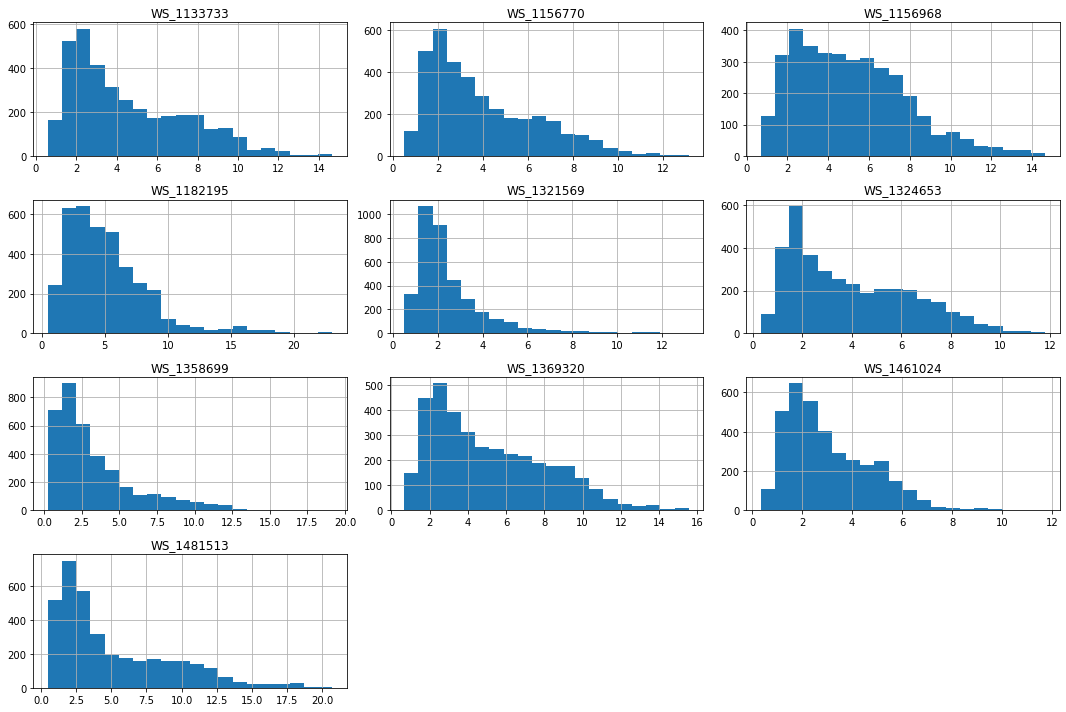

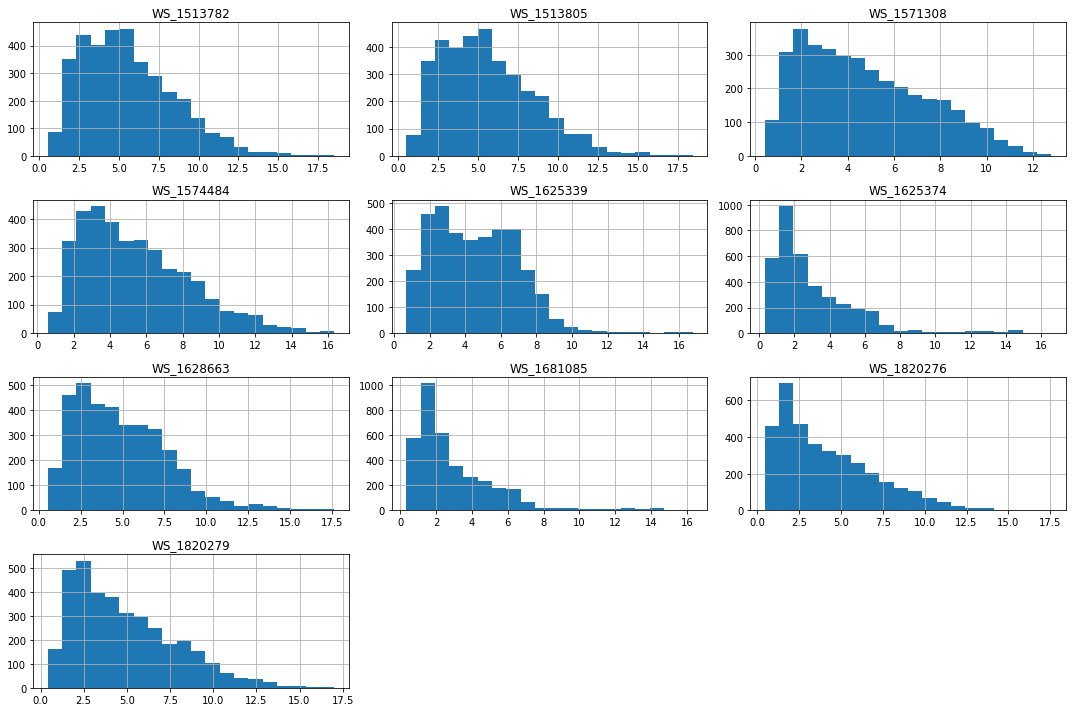

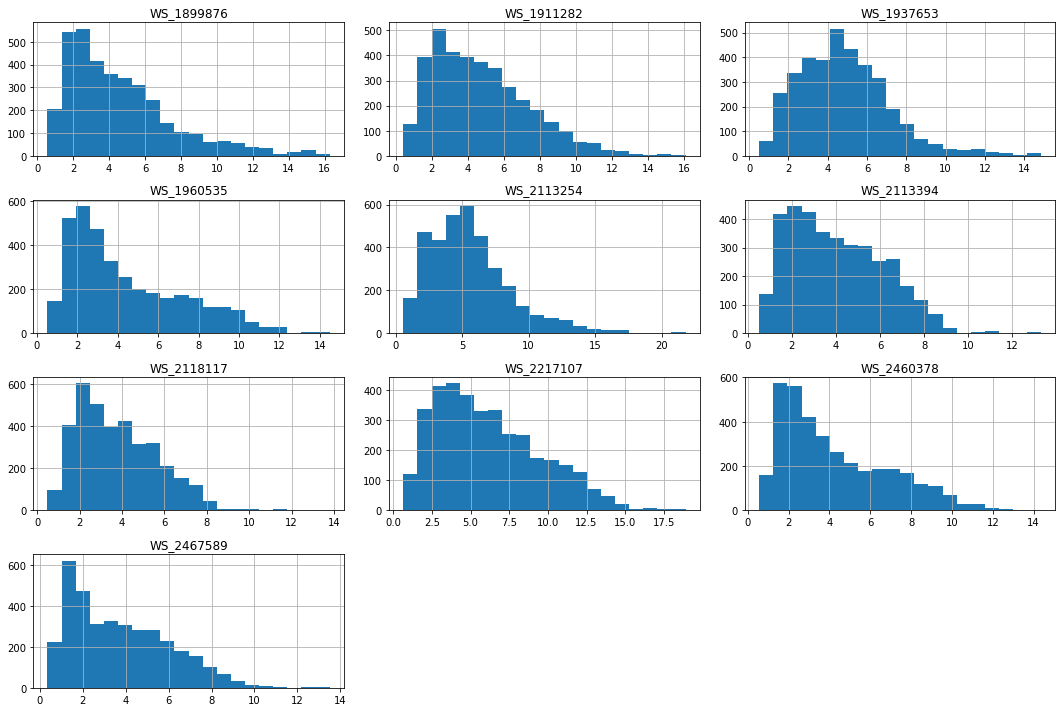

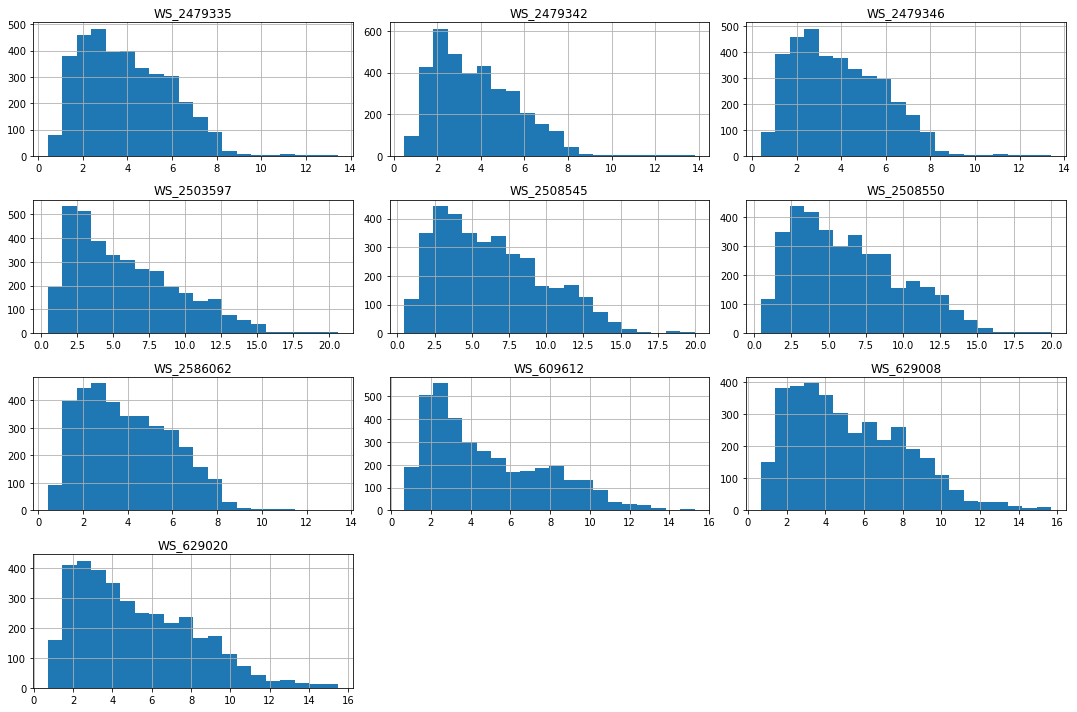

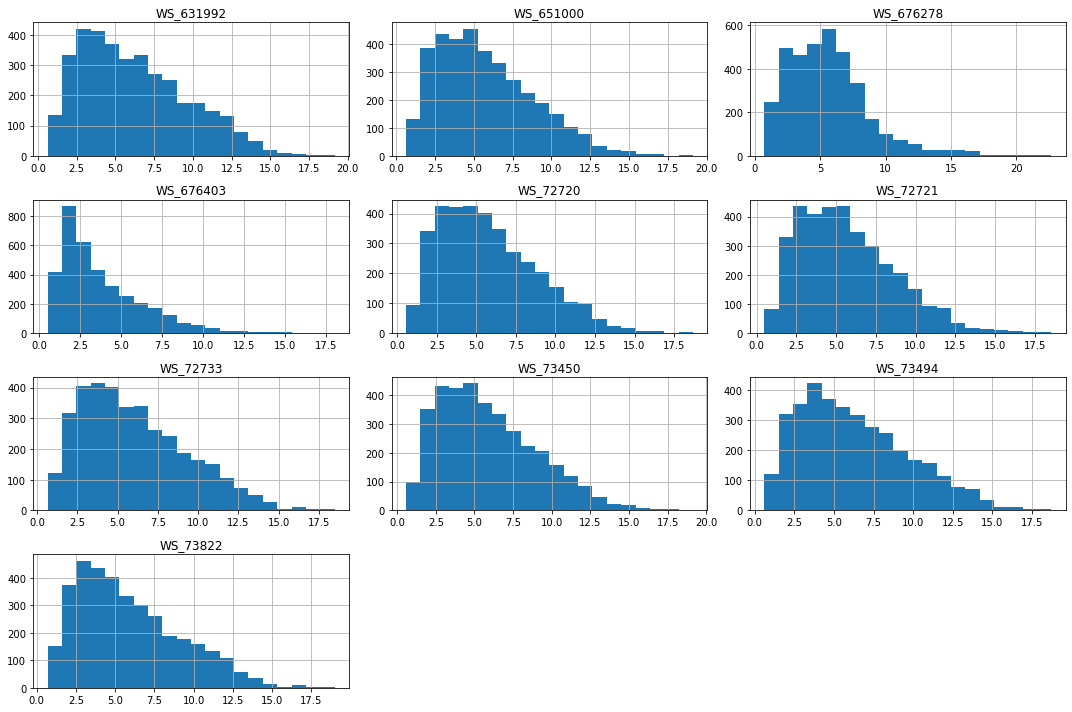

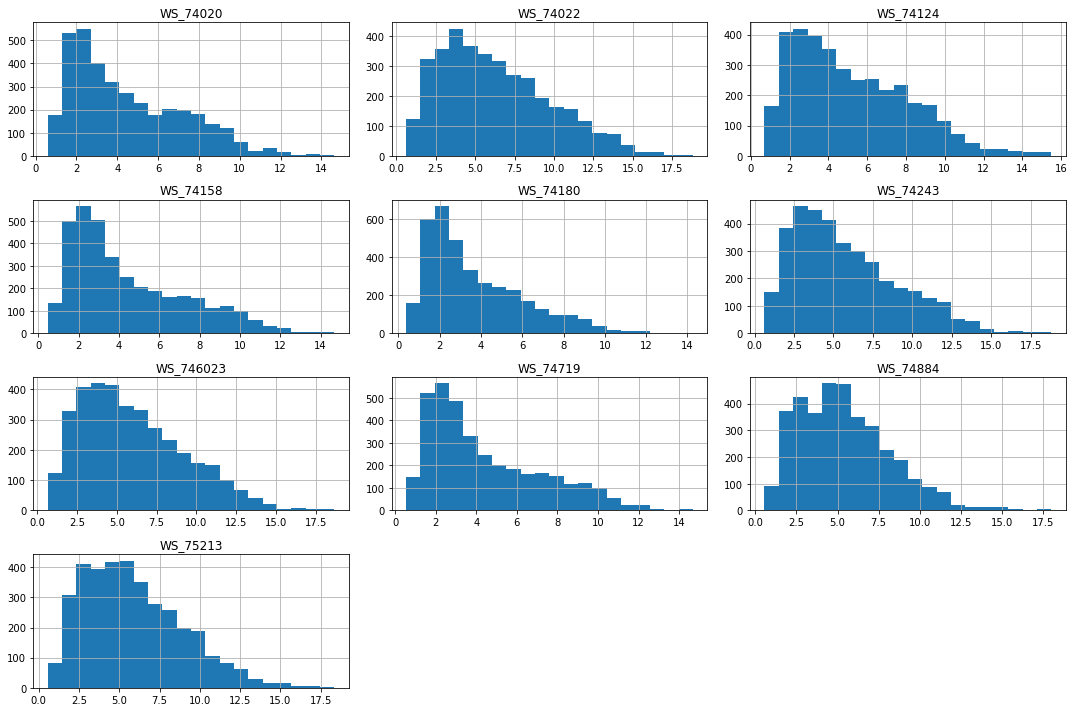

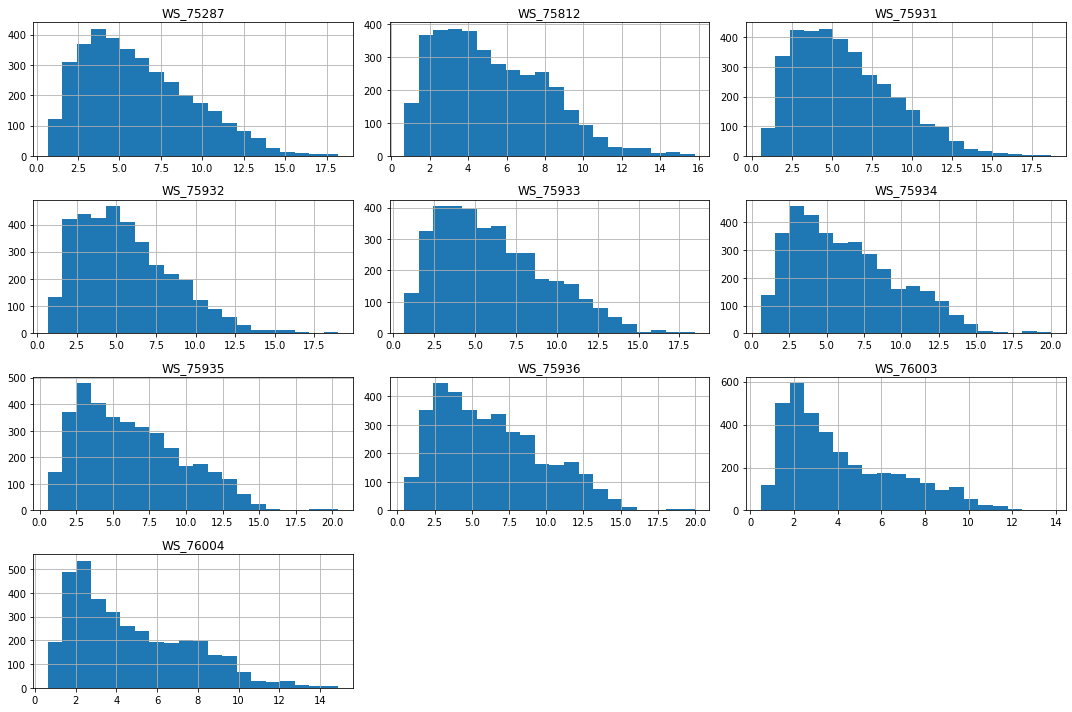

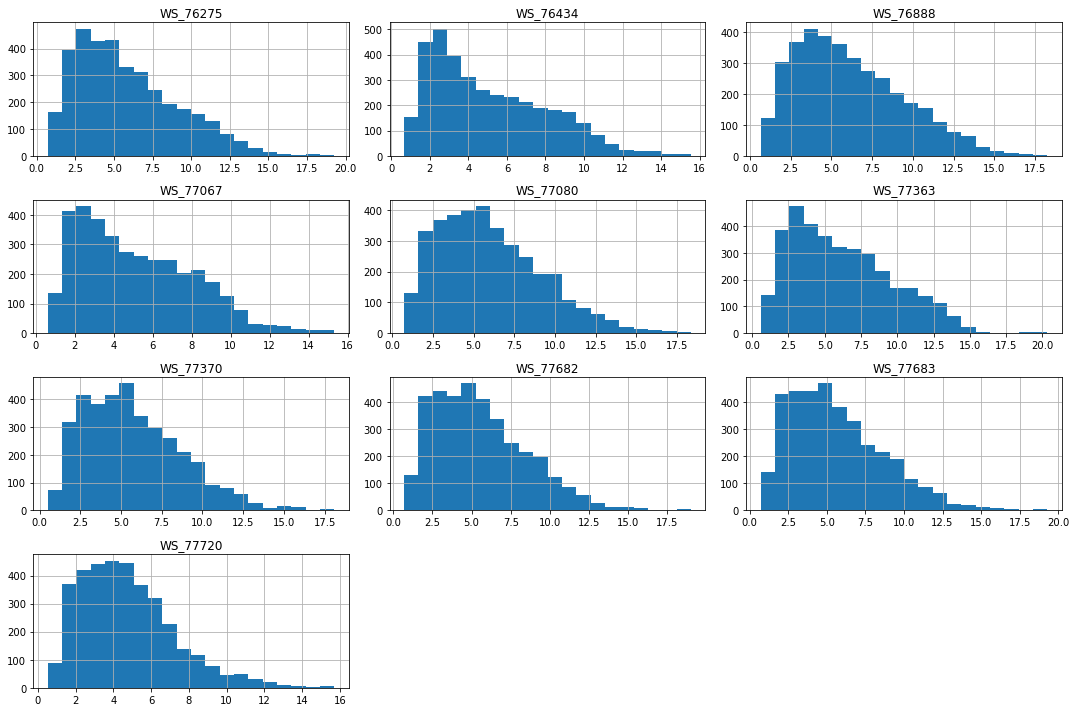

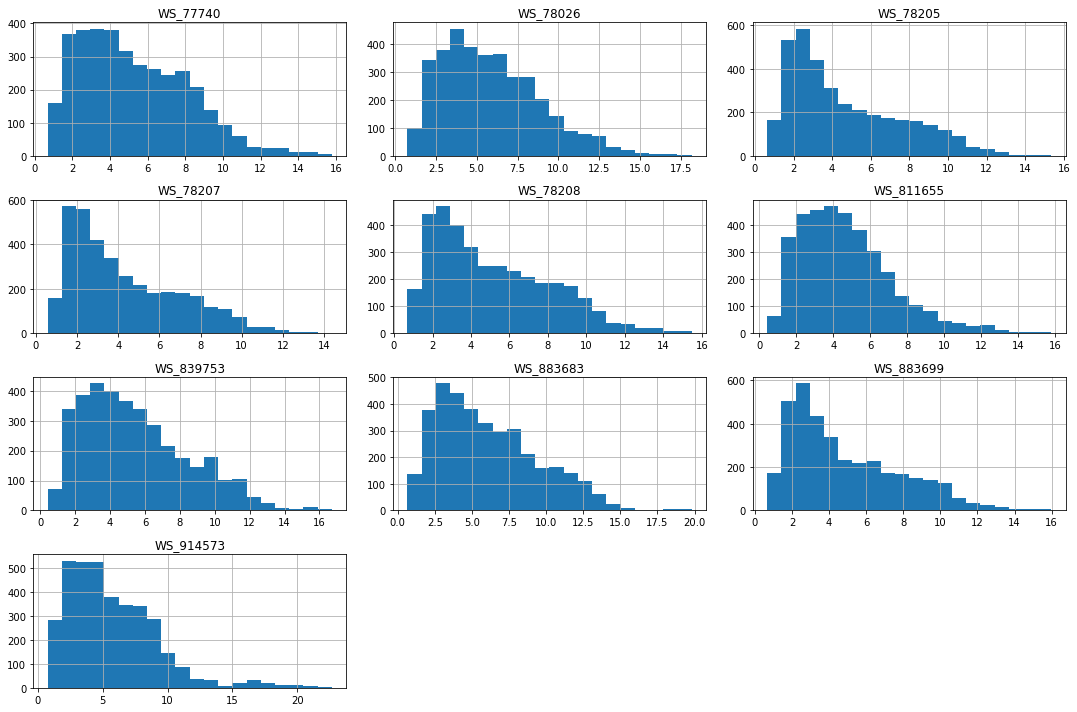

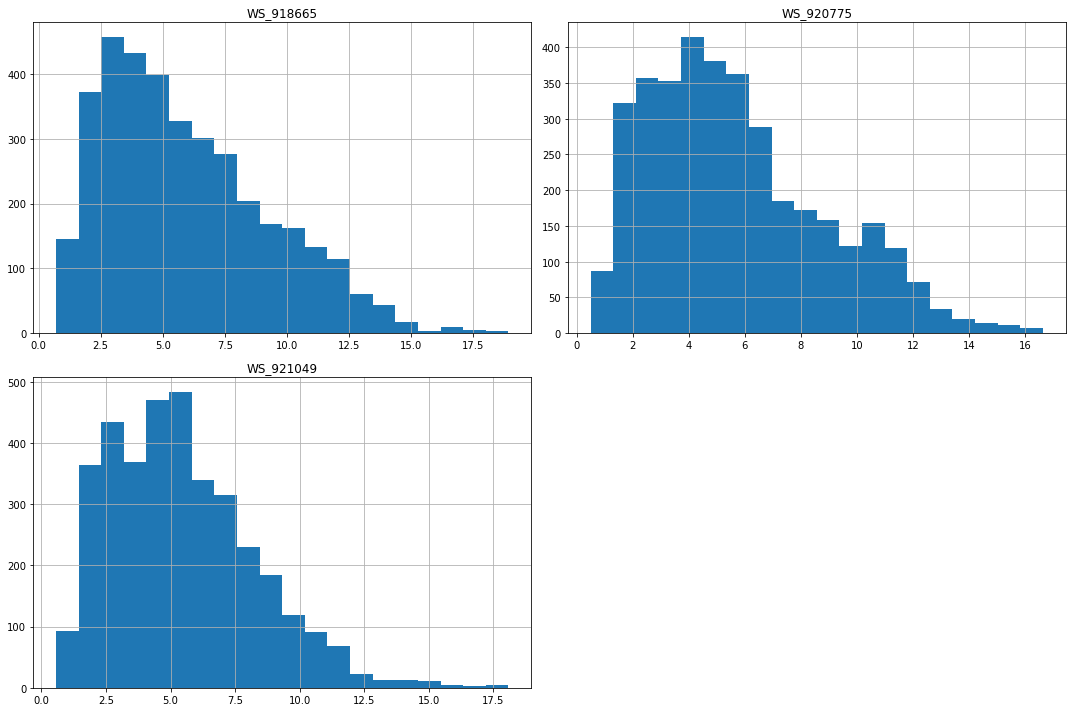

In [17]:
# Plot histograms for features that follow Skewed Distribution.
plot_histograms(data[column_Skewed], batch_size=10)

Above are histograms of features that follow Skewed Distribution.

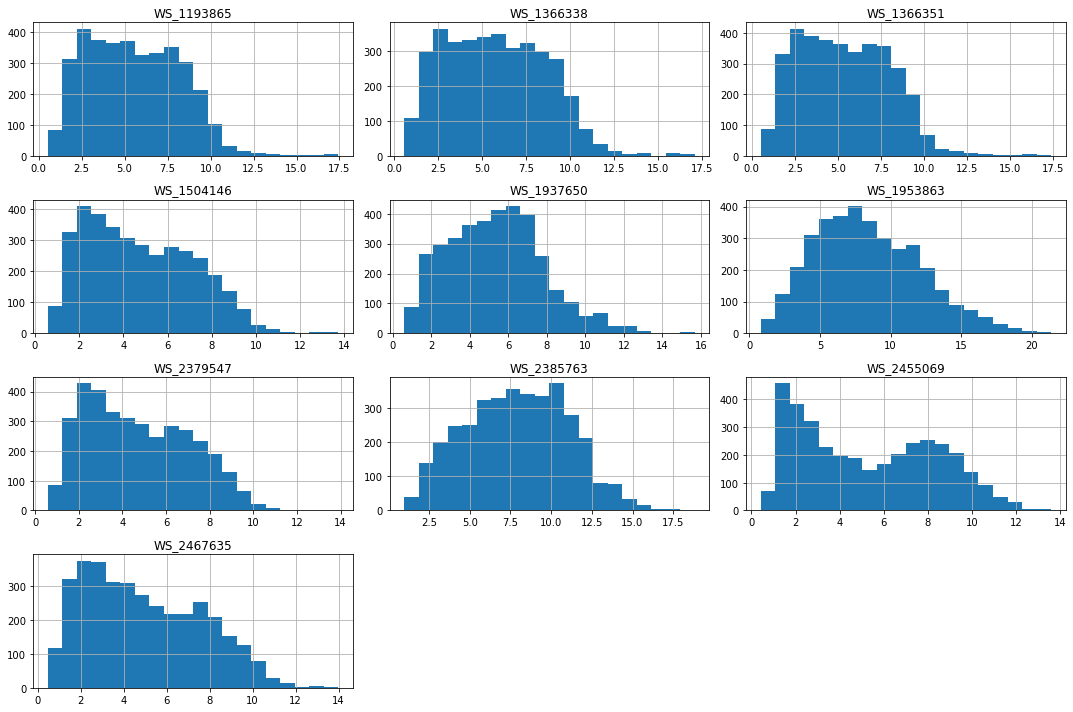

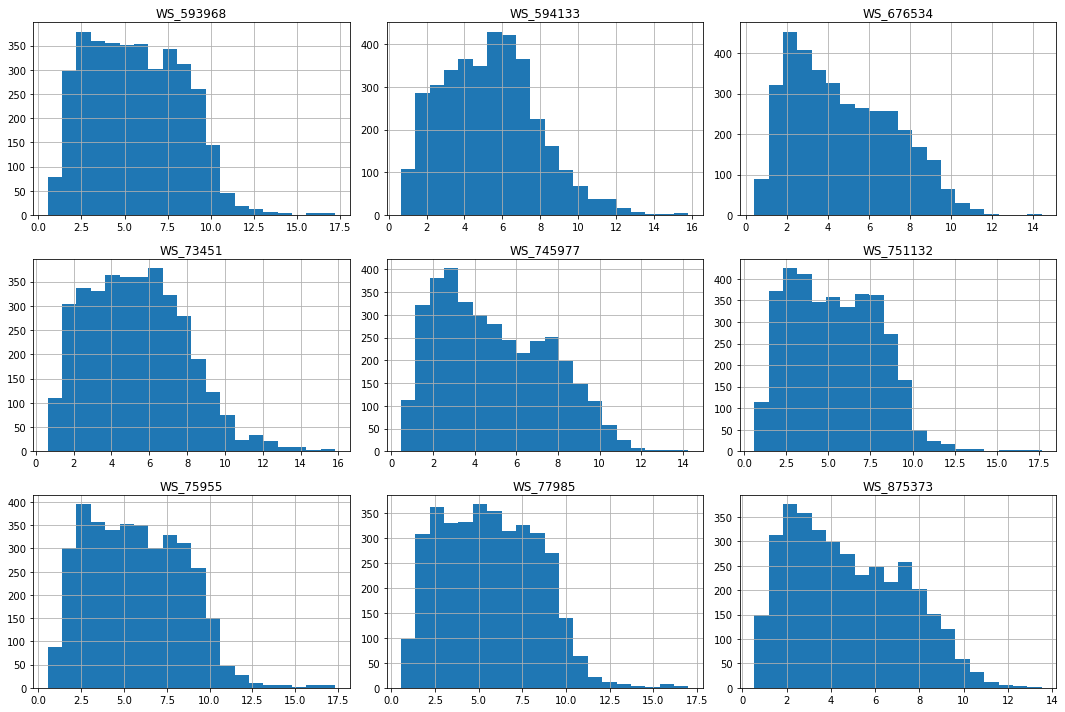

In [18]:
# Plot histograms for features that follow Uniform Distribution.
plot_histograms(data[column_Uniform], batch_size=10)

Above are histograms of features that follow Uniform Distribution.

**Brief summary about raw data:**

**1. Mean and Median Proximity**:
    The mean and median of the features are quite close, indicating a symmetrical distribution of data without significant skewness.

**2. Reasonable Range for Min and Max Values**:
    Both the minimum and maximum values of the features fall within reasonable ranges, suggesting the absence of outliers in the data.

**3. Comparable Standard Deviations**:
    The standard deviations of the features are similar in magnitude, indicating a consistent level of variability across different features.

**4. Distribution Characteristics**:
    From the histograms and numerical summaries of the distributions, it was observed that the wind speed values in most locations are approximately normally distributed.
    In a few locations, the wind speed distribution appears to be nearly uniform.

Now here is the distribution of each row in the dataset:

In [19]:
row_distribution_results = determine_distribution(data.drop('CF', axis=1).T)
row_distribution_results['Distribution Type'].value_counts().reset_index()

Distribution Type  count
0   Skewed Distribution   2079
1  Uniform Distribution   1430
2   Normal Distribution    126

As we can see, most features follow Skewed Distribution and Uniform Distribution, some features follow Normal Distribution.

Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.

In [20]:
def generate_percentiles(data):
    data['MIN_WS'] = data[ws_columns].min(axis=1)
    data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data['MAX_WS'] = data[ws_columns].max(axis=1)
    data['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data['STD_WS'] = data[ws_columns].std(axis=1)
    return data

In [21]:
data = generate_percentiles(data)

In [22]:
predict = generate_percentiles(predict)

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

In [23]:
def get_new_features(data):
    """
    Extracts new temporal features from the datetime index of a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame with a datetime index.

    Returns:
        pd.DataFrame: The DataFrame with new temporal features added.
    """
    # Get information from datetime to help generate seasons etc.
    data['YEAR'] = data.index.year
    data['MONTH'] = data.index.month
    data['DAY'] = data.index.day
    data['HOUR'] = data.index.hour

    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'

    # Define daylight and night based on hour (assuming 6 AM to 6 PM is daylight)
    def get_daylight_night(hour):
        if 6 <= hour < 18:
            return 'Daylight'
        else:
            return 'Night'

    # Define parts of the day
    def get_day_part(hour):
        if 0 <= hour < 6:
            return 'Morning'
        elif 6 <= hour < 12:
            return 'Midday'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Night'

    # Define weekay and weekend
    mapping1 = {
        0: 'Weekday',
        1: 'Weekday',
        2: 'Weekday',
        3: 'Weekday',
        4: 'Weekday',
        5: 'Weekend',
        6: 'Weekend',
    }

    mapping2 = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    # Generate important categorical features
    data['SEASON'] = data['MONTH'].apply(get_season)
    data['DAY_NIGHT'] = data['HOUR'].apply(get_daylight_night)
    data['DAY_PART'] = data['HOUR'].apply(get_day_part)
    data["IS_WEEKEND"] = data.index.weekday
    data['IS_WEEKEND'] = data['IS_WEEKEND'].apply(lambda x: mapping1[x])
    data['day_of_week'] = data.index.weekday
    data['day_of_week'] = data['day_of_week'].apply(lambda x: mapping2[x])

    return data

In [24]:
# Generate new features, get new dataset
data = get_new_features(data)

In [25]:
# Feature Engineering for predict
predict = get_new_features(predict)

Now I'm going to analyze categorical variable cardinality.

In [26]:
def get_proportion(feature):
    """
    Calculates the proportion of each unique value in the given feature column and returns it as a DataFrame.

    Args:
        feature (pd.Series): The feature column for which to calculate proportions.

    Returns:
        pd.DataFrame: A DataFrame containing the unique values and their corresponding proportions as percentages.
    """
    counts = feature.value_counts(normalize=True)
    percentages = counts * 100
    return percentages.reset_index()

In [27]:
# Calculate the proportion of each season
get_proportion(data['SEASON'])

SEASON  proportion
0    Fall   59.477304
1  Winter   24.594223
2  Summer   15.928473

The proportion of data points in autumn is higher compared to winter and summer.

So this data is more representative of fall and winter, suggesting that the model's predictions may be less accurate during colder temperatures.

A potential feature to explore is categorizing fall and winter as low temperature seasons, and summer as a high temperature season.

Note: It is important to check whether the test data includes spring.

In [28]:
# Calculate the proportion of each day
get_proportion(data['DAY_NIGHT'])

DAY_NIGHT  proportion
0  Daylight   50.261348
1     Night   49.738652

This demonstrates that the data is evenly distributed between day and night.

In [29]:
# Calculate the proportion of each day (4 parts)
get_proportion(data['DAY_PART'])

DAY_PART  proportion
0  Afternoon   25.199450
1     Midday   25.061898
2      Night   24.951857
3    Morning   24.786795

This further demonstrates that the data for parts of a day is evenly distributed.

In [30]:
# Calculate the proportion of each week
get_proportion(data['IS_WEEKEND'])

IS_WEEKEND  proportion
0    Weekday    72.13205
1    Weekend    27.86795

It was found that 72.13% of the data corresponds to weekdays, while 27.87% corresponds to weekends. Therefore, it can be concluded that the time series data provided is continuous, with no interruptions in the middle.

In [31]:
# Calculate the proportion of each week
get_proportion(data['day_of_week'])

day_of_week  proportion
0      Friday   14.497937
1   Wednesday   14.470426
2     Tuesday   14.470426
3    Thursday   14.387895
4      Monday   14.305365
5    Saturday   14.030261
6      Sunday   13.837689

This demonstrates that the data is evenly dimstributed among week.

In [32]:
# Calculate the proportion of each month
get_proportion(data['MONTH'])

MONTH  proportion
0     12   20.412655
1     10   19.889959
2      9   19.807428
3     11   19.779917
4      8   15.928473
5      1    4.181568

This demonstrates that the data is evenly distributed among month.

C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\13360\anaconda3\lib\si

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

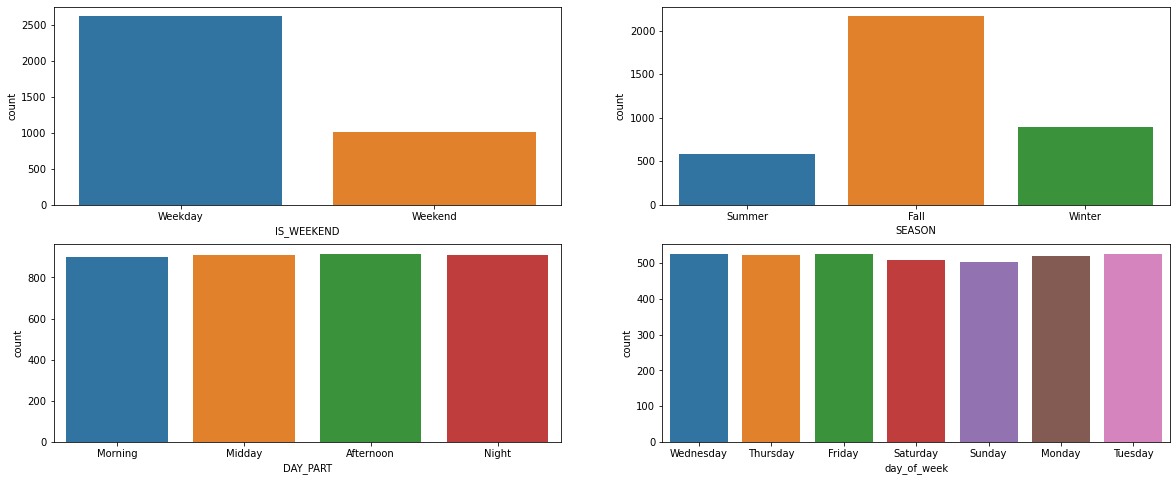

In [33]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.countplot(data['IS_WEEKEND'])
fig.add_subplot(2,2,2)
sns.countplot(data['SEASON'])
fig.add_subplot(2,2,3)
# sns.countplot(data['DAY_NIGHT'])
sns.countplot(data['DAY_PART'])
fig.add_subplot(2,2,4)
sns.countplot(data['day_of_week'])

**Univariate Analysis Summary**:
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation

In [34]:
# Prepare Features and Target
ws_sts_columns = [col for col in data.columns if 'WS' in col]
X = data[ws_sts_columns]
y = data['CF']

pearson_results = []
spearman_results = []

# Compute Pearson and Spearman correlations
for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        pearson_corr, _ = pearsonr(X[column], y)
        spearman_corr, _ = spearmanr(X[column], y)
        pearson_results.append({'WS_location': column, 'Pearson Correlation': pearson_corr})
        spearman_results.append({'WS_location': column, 'Spearman Correlation': spearman_corr})

pearson_df = pd.DataFrame(pearson_results).sort_values(by='Pearson Correlation', ascending=False)
spearman_df = pd.DataFrame(spearman_results).sort_values(by='Spearman Correlation', ascending=False)

pearson_spearman = pd.merge(pearson_df, spearman_df, on='WS_location')

In [35]:
pearson_spearman

WS_location  Pearson Correlation  Spearman Correlation
0       MEAN_WS             0.867128              0.884486
1    WS_2503597             0.848757              0.827564
2        P75_WS             0.845775              0.878471
3     MEDIAN_WS             0.842367              0.851489
4    WS_2508550             0.841939              0.840181
5    WS_2508545             0.840002              0.841517
6      WS_75936             0.839991              0.841491
7      WS_75935             0.837190              0.839795
8      WS_75934             0.834120              0.837020
9      WS_77363             0.833789              0.836939
10    WS_631992             0.832899              0.836297
11   WS_2217107             0.827572              0.831508
12     WS_74022             0.825647              0.827482
13     WS_73494             0.824682              0.827318
14    WS_883683             0.823975              0.824556
15     WS_75933             0.822006              0.826455
16     WS_76888             0.819515              0.824628
17     WS_75287             0.819324              0.824631
18     WS_72733             0.818889              0.823824
19    WS_746023             0.816846              0.821652
20    WS_918665             0.811993              0.811520
21       P95_WS             0.809580              0.860826
22     WS_73822             0.807577              0.806093
23       P25_WS             0.807461              0.786247
24     WS_73450             0.804148              0.810261
25     WS_76275             0.801048              0.800261
26     WS_74243             0.798275              0.793313
27     WS_78026             0.796480              0.816840
28   WS_1574484             0.792030              0.803766
29     WS_72720             0.790883              0.797036
30     WS_75931             0.790830              0.797453
31    WS_651000             0.790279              0.796273
32     WS_75213             0.786302              0.794575
33     WS_77080             0.782622              0.791390
34    WS_839753             0.777407              0.766105
35     WS_72721             0.773094              0.781865
36     WS_77370             0.769006              0.778105
37     WS_77683             0.767702              0.773689
38   WS_2455069             0.761114              0.785805
39     WS_75932             0.761016              0.768661
40     WS_77682             0.761016              0.768661
41   WS_1513805             0.758911              0.769526
42    WS_920775             0.757800              0.740307
43   WS_1513782             0.754954              0.765600
44    WS_921049             0.726670              0.738631
45     WS_74020             0.725567              0.707332
46     WS_76004             0.725562              0.706955
47    WS_609612             0.725331              0.701420
48   WS_1133733             0.724801              0.700641
49     WS_74884             0.722280              0.734247
50   WS_1369320             0.720789              0.703879
51     WS_76434             0.720784              0.703961
52     WS_78208             0.720730              0.705591
53     WS_77067             0.717994              0.708005
54     WS_78205             0.717554              0.686592
55     WS_78207             0.716036              0.692336
56   WS_2460378             0.714782              0.690396
57   WS_1960535             0.712396              0.679724
58     WS_76003             0.710666              0.682623
59   WS_1156770             0.710433              0.689210
60     WS_74719             0.707973              0.673787
61     WS_74158             0.704835              0.669947
62    WS_883699             0.704502              0.678956
63   WS_1481513             0.696518              0.691999
64     WS_74124             0.691743              0.678546
65    WS_629020             0.691711              0.678310
66    WS_629008             0.688044              0

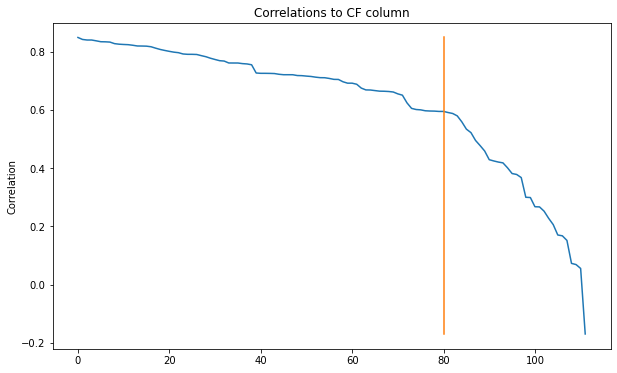

In [36]:
# reason why we choose 80 columns for XGBoost without lag model
plt.figure(figsize=(10,6))
plt.plot(sorted(pearson_spearman[pearson_spearman.WS_location.str.startswith('WS')]['Pearson Correlation'], reverse=True))
plt.plot([80,80],[min(pearson_spearman[pearson_spearman.WS_location.str.startswith('WS')]['Pearson Correlation']), max(pearson_spearman[pearson_spearman.WS_location.str.startswith('WS')]['Pearson Correlation'])])
plt.title('Correlations to CF column')
plt.ylabel('Correlation')
plt.show()

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation
- Categorical analysis

**ANOVA Test**

In [37]:
from scipy.stats import f_oneway, ttest_ind

class1= data[data['SEASON']=='Summer']['CF']
class2= data[data['SEASON']=='Fall']['CF']
class3= data[data['SEASON']=='Winter']['CF']

pval1 = f_oneway(class1, class2, class3)[1]
# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature SEASON:\n',f_oneway(class1, class2, class3))

This is the ANOVA-test result of feature SEASON:
 F_onewayResult(statistic=83.08876803021315, pvalue=5.202013210703249e-36)


The feature SEASON is correlated with the target value, indicating that the season significantly affects the electricity output.

In [38]:
class1= data[data['day_of_week']=='Monday']['CF']
class2= data[data['day_of_week']=='Tuesday']['CF']
class3= data[data['day_of_week']=='Wednesday']['CF']
class4= data[data['day_of_week']=='Thursday']['CF']
class5= data[data['day_of_week']=='Friday']['CF']
class6= data[data['day_of_week']=='Saturday']['CF']
class7= data[data['day_of_week']=='Sunday']['CF']

pval2 = f_oneway(class1, class2, class3, class4, class5, class6, class7)[1]
# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature day_of_week:\n',f_oneway(class1, class2, class3, class4, class5, class6, class7))

This is the ANOVA-test result of feature day_of_week:
 F_onewayResult(statistic=8.217475502611896, pvalue=7.45666768797419e-09)


The feature day_of_week is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [39]:
class1= data[data['DAY_PART']=='Morning']['CF']
class2= data[data['DAY_PART']=='Midday']['CF']
class3= data[data['DAY_PART']=='Afternoon']['CF']
class4= data[data['DAY_PART']=='Night']['CF']

pval3 = f_oneway(class1, class2, class3, class4)[1]
# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature DAY_PART:\n',f_oneway(class1, class2, class3, class4))

This is the ANOVA-test result of feature DAY_PART:
 F_onewayResult(statistic=68.68120772570627, pvalue=3.393868596506757e-43)


The feature DAY_PART is correlated with the target value, indicating that the feature significantly affects the electricity output.

**T-test**

In [40]:
class1= data[data['DAY_NIGHT']=='Night']['CF']
class2= data[data['DAY_NIGHT']=='Daylight']['CF']

pval4 = ttest_ind(class1, class2)[1]
# Conduct the t-test
print('This is the T-test result of feature DAY_NIGHT:\n',ttest_ind(class1, class2))

This is the T-test result of feature DAY_NIGHT:
 Ttest_indResult(statistic=13.82232140933804, pvalue=2.172226869557305e-42)


The feature DAY_NIGHT is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [41]:
class1= data[data['IS_WEEKEND']=='Weekday']['CF']
class2= data[data['IS_WEEKEND']=='Weekend']['CF']

pval5 = ttest_ind(class1, class2)[1]
# Conduct the t-test
print('This is the T-test result of feature IS_WEEKEND:\n',ttest_ind(class1, class2))

This is the T-test result of feature IS_WEEKEND:
 Ttest_indResult(statistic=1.3132394681703519, pvalue=0.1891852034969178)


In [42]:
pd.DataFrame({'Test':['ANOVA','ANOVA', 'ANOVA', 't-test', 't-test'],
              'P Value':[pval1, pval2, pval3, pval4, pval5]}, 
             index=['SEASON','day_of_week','DAY_PART', 'DAY_NIGHT', 'IS_WEEKEND'])

Test       P Value
SEASON        ANOVA  5.202013e-36
day_of_week   ANOVA  7.456668e-09
DAY_PART      ANOVA  3.393869e-43
DAY_NIGHT    t-test  2.172227e-42
IS_WEEKEND   t-test  1.891852e-01

The feature IS_WEEKEND is not correlated with the target value, indicating that there is no significant difference between this feature.

<AxesSubplot:xlabel='day_of_week', ylabel='CF'>

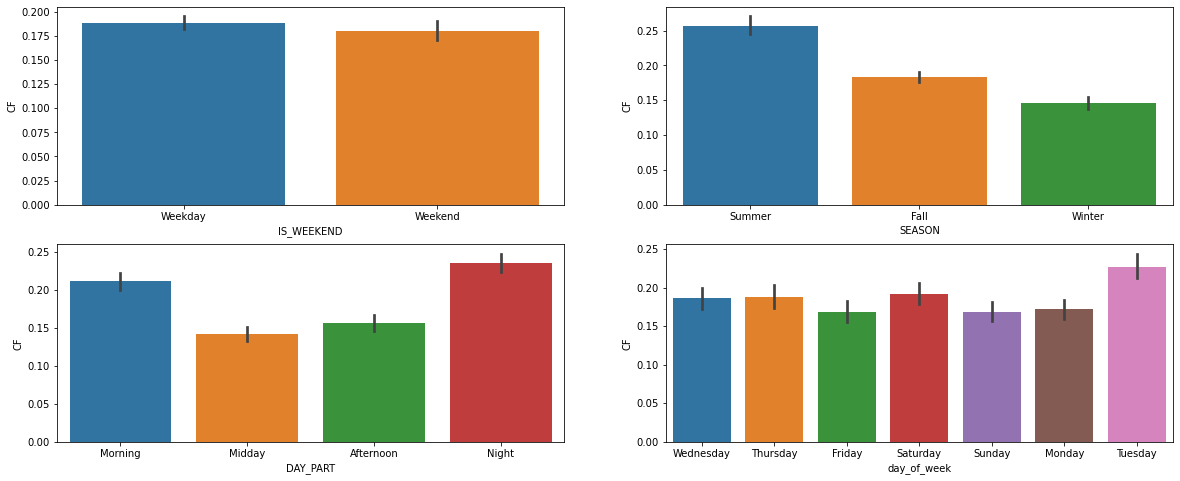

In [43]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.barplot(x='IS_WEEKEND', y='CF', data = data)
fig.add_subplot(2,2,2)
sns.barplot(x='SEASON', y='CF', data = data)
fig.add_subplot(2,2,3)
# sns.barplot(data, x='DAY_NIGHT', y='CF')
sns.barplot(x='DAY_PART', y='CF', data = data)
fig.add_subplot(2,2,4)
sns.barplot(x='day_of_week', y='CF', data = data)

The average value of CF varies across different SEASONS and dayparts.

The bar plot shows numerical values. Now here are distribution plot.

In [44]:
def plot_distribution(data,feature_name, classifications_to_vis):
    """
  Plots the density distribution of the 'CF' feature for different classifications.

  Args:
      data (pd.DataFrame): The dataset containing the features.
      feature_name (str): The column name to group by for classifications (e.g., 'SEASON').
      classifications_to_vis (list): The list of classification values to visualize (e.g., ['Summer', 'Fall']).
      """
    plt.figure(figsize=(10, 3))
    for classification in classifications_to_vis:
        data[data[feature_name] == classification]['CF'].plot(kind='density', label=classification)

    plt.xlim(0, 1.3)
    plt.legend()
    plt.title(f'Distribution of CF for Different Classifications')
    plt.show()

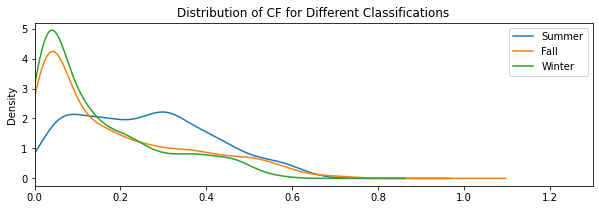

In [45]:
plot_distribution(data, 'SEASON', ['Summer', 'Fall', 'Winter'])

The bar plot only shows numerical values, but the distribution reveals that summer differs significantly from fall and winter.

This observation confirms our earlier hypothesis: we can create a new feature for temperature categorization.

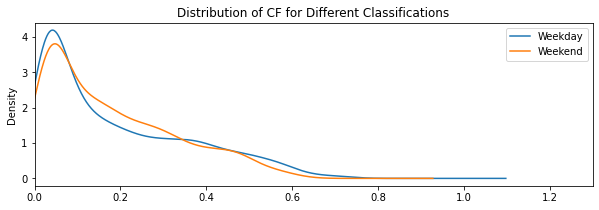

In [46]:
plot_distribution(data, 'IS_WEEKEND', ['Weekday', 'Weekend'])

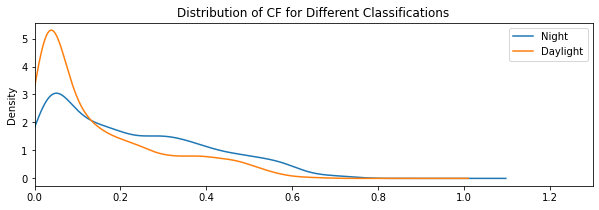

In [47]:
plot_distribution(data, 'DAY_NIGHT', ['Night', 'Daylight'])

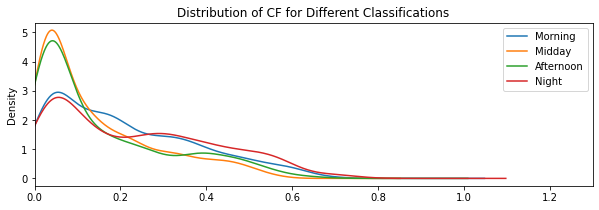

In [48]:
plot_distribution(data, 'DAY_PART', ['Morning', 'Midday', 'Afternoon', 'Night'])

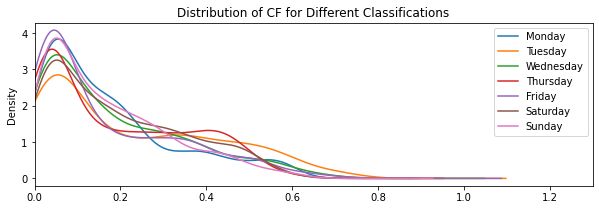

In [49]:
plot_distribution(data, 'day_of_week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])

Now here is the time series of features and target with dual axes.

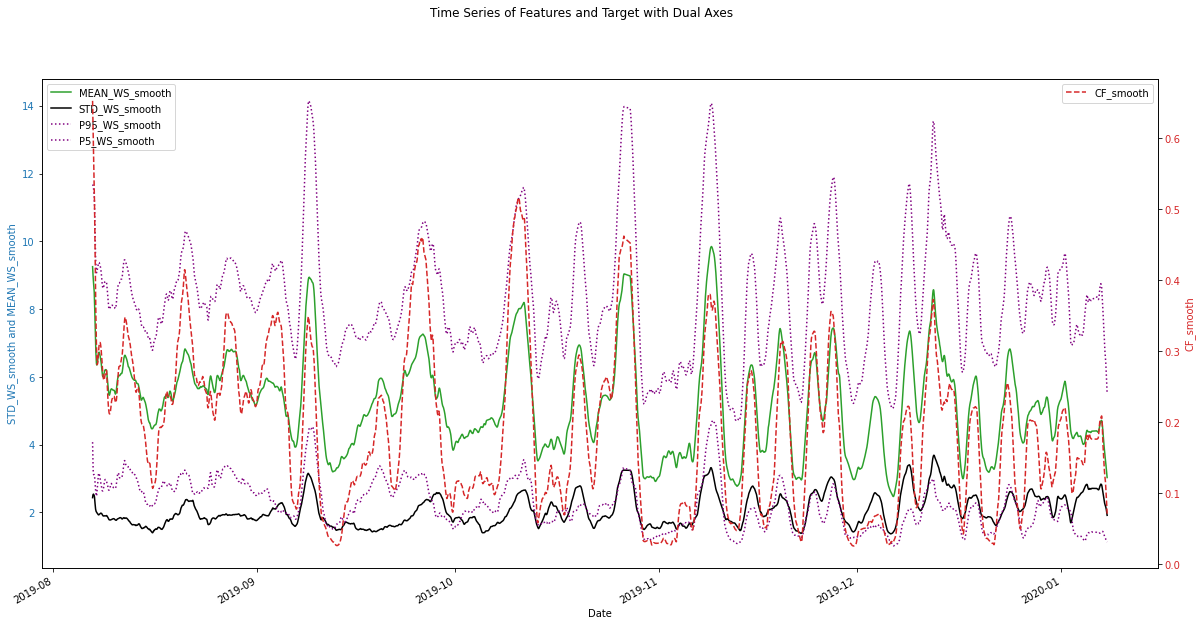

In [50]:
numerical_data = data.select_dtypes(include=[np.number])
numerical_data['CF_smooth'] = numerical_data['CF'].rolling(window=48, min_periods=1).mean()
numerical_data['MEAN_WS_smooth'] = numerical_data['MEAN_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['STD_WS_smooth'] = numerical_data['STD_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P95_WS_smooth'] = numerical_data['P95_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P5_WS_smooth'] = numerical_data['P5_WS'].rolling(window=48, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(20, 10))

numerical_data['MEAN_WS_smooth'].plot(ax=ax1,label='MEAN_WS_smooth', color='tab:green')
numerical_data['STD_WS_smooth'].plot(ax=ax1,label='STD_WS_smooth', color='black')
numerical_data['P95_WS_smooth'].plot(ax=ax1,label='P95_WS_smooth', color='purple', linestyle=':')
numerical_data['P5_WS_smooth'].plot(ax=ax1,label='P5_WS_smooth', color='purple', linestyle=':')

ax1.set_xlabel('Date')
ax1.set_ylabel('STD_WS_smooth and MEAN_WS_smooth', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()

numerical_data['CF_smooth'].plot(ax=ax2,label='CF_smooth', color='tab:red', linestyle='--')
ax2.set_ylabel('CF_smooth', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Time Series of Features and Target with Dual Axes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

The analysis reveals that:
- Wind speeds from previous time points influence the current wind speed.
- The current wind speed is strongly correlated with electricity output.

Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

# Feature Engineering & Part of EDA

In [51]:
def get_data_final(data, correlation):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:70]['WS_location'].to_list()
    data_final = data[high_cor_list].copy()

    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)

    data_final = pd.merge(data_final, data.select_dtypes(include='object'), left_index=True, right_index=True)
    data_final['CF'] = data['CF']
    cols = data_final.columns.tolist()
    new_order = [cols[-1]] + cols[:-1]
    data_final = data_final[new_order]

    return data_final

In [52]:
data_final = get_data_final(data, pearson_spearman)
predict_final = get_data_final(predict, pearson_spearman)

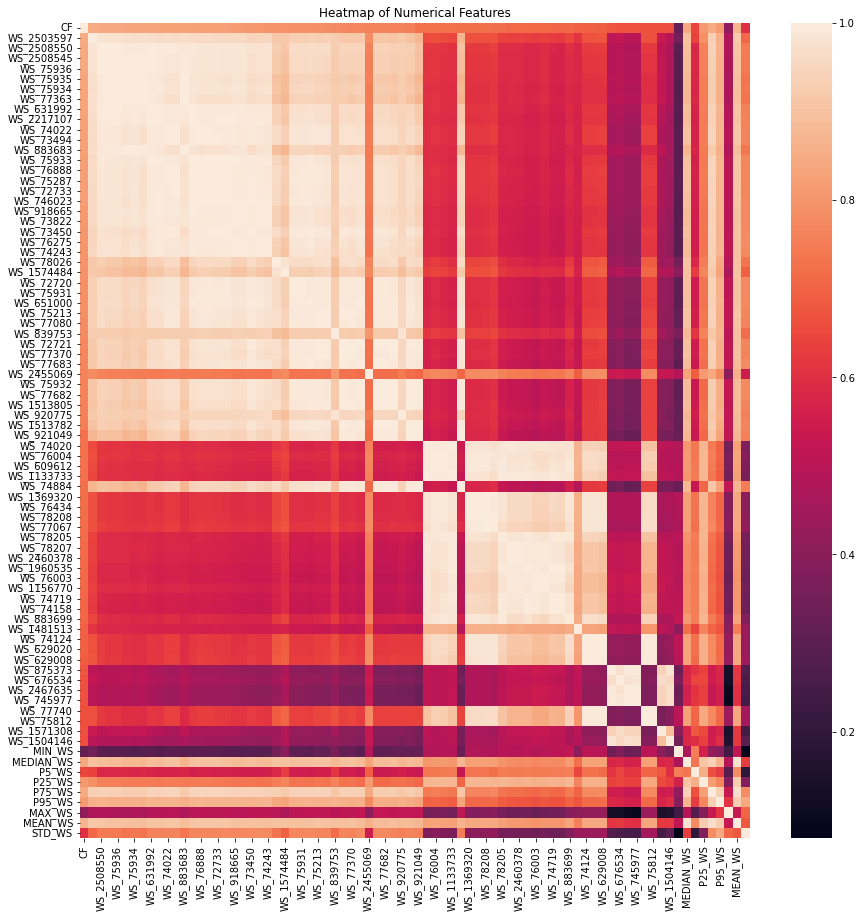

In [53]:
numerical_columns = data_final.select_dtypes(include=[np.number])
plt.figure(figsize=(15,15))
sns.heatmap(numerical_columns.corr())
plt.title('Heatmap of Numerical Features')
plt.show()

## Multivariate Analysis

### Linear Regression - Feature Selection

In [54]:
s = ''
for col_name in data_final.columns[1:]:
    if col_name in data_final.columns[-5:]:
        s += f' + C({col_name})'
    else:
        s += f' + {col_name}'
s = ' ~' + s[2:]

In [55]:
formula= 'CF' + s
mod = smf.ols(formula, data=data)
res = mod.fit()
print(res.summary())
print('---------------------------------------------------------------------------------------------------')
print('\t')

                            OLS Regression Results                            
Dep. Variable:                     CF   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     301.3
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:15:51   Log-Likelihood:                 5292.2
No. Observations:                3635   AIC:                        -1.040e+04
Df Residuals:                    3545   BIC:                            -9846.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The IS_WEEKEND feature shows no significant differences in its impact on Y in univariate, bivariate, or multivariate analysis. Therefore, this feature has no predictive power and should be discarded.

This also indicates that these **9 key percentilesare** likely to be statistically significant. This could imply that these measures are important in understanding the distribution and variability of the data, influencing decisions or insights derived from the analysis.

### Decision Tree - Feature Selection

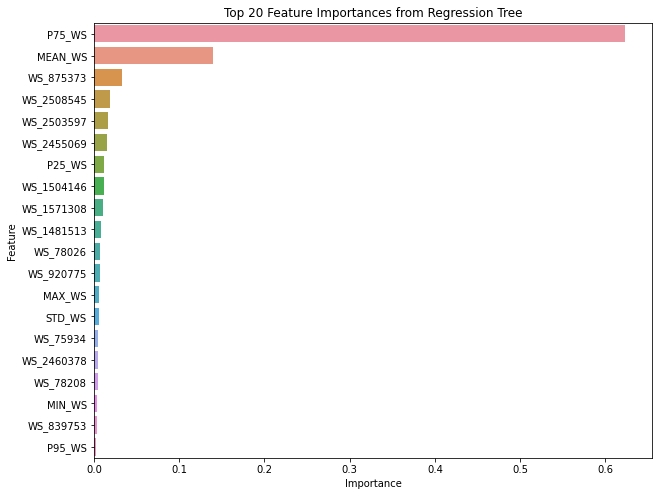

In [56]:
X = data_final.drop(columns=['CF'])
y = data_final['CF']
categorical_columns = data_final.select_dtypes('object').columns.to_list()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the model
pipeline.fit(X, y)
regressor = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']

preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Get Feature Importances
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + encoded_feature_names.tolist()

importances = regressor.feature_importances_

feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot only the top 20 features
top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n))
plt.title(f'Top {top_n} Feature Importances from Regression Tree')
plt.show()

Logically, we would expect that the average wind speed around the wind farm would have the most significant impact on electricity generation. However, the feature importance analysis indicates that the 75th percentile wind speed has a greater influence.

**Brief summary on Multivariate Analysis:**

Based on the coefficients from **OLS regression** and the feature importance from the **decision tree**, I explored both the linear and nonlinear relationships between features and the target value. This analysis allowed me to perform an initial feature selection.

In [57]:
data_final.drop(columns=['IS_WEEKEND'], inplace=True)

In [58]:
predict_final.drop(columns=['IS_WEEKEND'], inplace=True)

The feature engineering process is now complete, resulting in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

Now I start modeling.

# Model1: XGBoost without Lagged Features

#### Apply oneHotEncoder to categorical feature 

In [168]:
# feature engineering
def get_final_data_xgb(data, correlation):
    # Select wind speed features with top 80 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:80]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Generate categorical features and apply oneHotEncoder
    categorical_columns = ['SEASON', 'DAY_PART']
    temp = data[categorical_columns].copy()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(temp)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df.index = data_final.index
    data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)
    
    return data_final

data_final_xgb0 = get_final_data_xgb(data, pearson_spearman)
data_final_xgb0.tail()

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2020-01-07 19:00:00  0.004494        0.90        0.96        1.34      1.34   
2020-01-07 20:00:00  0.006143        0.84        0.58        0.90      0.90   
2020-01-07 21:00:00  0.008399        1.06        0.90        0.97      0.97   
2020-01-07 22:00:00  0.015788        0.81        0.84        0.79      0.79   
2020-01-07 23:00:00  0.011883        0.82        0.82        0.74      0.74   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-07 19:00:00      1.56      1.65      1.66       1.48        1.54   
2020-01-07 20:00:00      1.08      1.23      1.23       1.09        1.29   
2020-01-07 21:00:00      1.06      1.20      1.15       1.15        1.35   
2020-01-07 22:00:00      0.82      0.85      0.82       0.92        1.19   
2020-01-07 23:00:00      0.77      0.73      0.77       0.74        0.87   

                     WS_74022  WS_73494  WS_883683  WS_75933  WS_76888  \
DATETIME                                                                 
2020-01-07 19:00:00      1.01      1.03       1.55      1.47      1.28   
2020-01-07 20:00:00      0.80      0.84       1.32      1.29      1.05   
2020-01-07 21:00:00      1.01      1.03       1.37      1.37      1.18   
2020-01-07 22:00:00      1.14      1.13       1.06      1.29      1.17   
2020-01-07 23:00:00      0.94      0.90       0.86      0.93      0.90   

                     WS_75287  WS_72733  WS_746023  WS_918665  WS_73822  \
DATETIME                                                                  
2020-01-07 19:00:00      1.36      1.44       1.43       1.30      1.23   
2020-01-07 20:00:00      1.13      1.30       1.36       1.42      1.39   
2020-01-07 21:00:00      1.24      1.38       1.43       1.44      1.41   
2020-01-07 22:00:00      1.22      1.34       1.40       1.54      1.53   
2020-01-07 23:00:00      0.91      0.96       1.00       1.06      1.03   

                     WS_73450  WS_76275  WS_74243  WS_78026  WS_1574484  \
DATETIME                                                                  
2020-01-07 19:00:00      1.40      1.21      1.12      1.53        1.14   
2020-01-07 20:00:00      1.51      1.41      1.28      1.57        1.12   
2020-01-07 21:00:00      1.58      1.43      1.31      1.77        1.32   
2020-01-07 22:00:00      1.61      1.56      1.46      1.96        1.25   
2020-01-07 23:00:00      1.10      1.04      0.97      1.83        1.15   

                     WS_72720  WS_75931  WS_651000  WS_75213  WS_77080  \
DATETIME                                                                 
2020-01-07 19:00:00      1.41      1.41       1.37      1.11      1.08   
2020-01-07 20:00:00      1.69      1.69       1.61      1.12      1.07   
2020-01-07 21:00:00      1.79      1.79       1.69      1.37      1.36   
2020-01-07 22:00:00      1.84      1.84       1.74      1.54      1.51   
2020-01-07 23:00:00      1.04      1.04       1.18      1.13      1.20   

                     WS_839753  WS_72721  WS_77370  WS_77683  WS_2455069  \
DATETIME                                                                   
2020-01-07 19:00:00       1.04      1.36      1.10      1.59        1.61   
2020-01-07 20:00:00       0.88      1.64      1.15      1.82        1.66   
2020-01-07 21:00:00       1.28      1.77      1.41      1.89        1.64   
2020-01-07 22:00:00       1.37      1.80      1.60      1.97        1.63   
2020-01-07 23:00:00       1.20      1.21      1.16      1.41        1.40   

                     WS_75932  WS_77682  WS_1513805  WS_920775  WS_1513782  \
DATETIME                                                                     
2020-01-07 19:00:00      1.60      1.60        1.44       1.22        1.54   
2020-01-07 20:00:00      1.86      1.86        1.73       1.05        1.84   
2020-

In [169]:
data_final_xgb0.shape

(3635, 97)

### Train Test Split by Time Order

In [170]:
test_split0 = round(len(data_final_xgb0)*0.20)
train_data0, test_data0 = data_final_xgb0[:-test_split0], data_final_xgb0[-test_split0:]
X_train0, y_train0 = train_data0.drop(columns=['CF']), train_data0['CF']
X_test0, y_test0 = test_data0.drop(columns=['CF']), test_data0['CF']

print(X_train0.shape, X_test0.shape)

(2908, 96) (727, 96)


### Modeling

In [171]:
# XGBoost Modeling
import xgboost as xgb
xgb_model0 = xgb.XGBRegressor(random_state=42)

param_grid_xgb0 = {
    'n_estimators': [600, 700],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

tscv0 = TimeSeriesSplit(n_splits=5)

grid_search_xgb0 = GridSearchCV(estimator=xgb_model0, param_grid=param_grid_xgb0, cv=tscv0, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_xgb0.fit(X_train0, y_train0)

best_xgb_model0 = grid_search_xgb0.best_estimator_
best_xgb_params0 = grid_search_xgb0.best_params_
best_xgb_score0 = -grid_search_xgb0.best_score_

print("Best parameters found: ", best_xgb_params0)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


In [172]:
print("Best mean absolute error: ", best_xgb_score0)
y_pred_xgb0 = best_xgb_model0.predict(X_test0)
test_mae_xgb0 = mean_absolute_error(y_test0, y_pred_xgb0)
print("Test mean absolute error: ", test_mae_xgb0)

Best mean absolute error:  0.04881452203258402
Test mean absolute error:  0.041682525597827404


In [173]:
y_pred_xgb0_test_plt = y_pred_xgb0.copy()

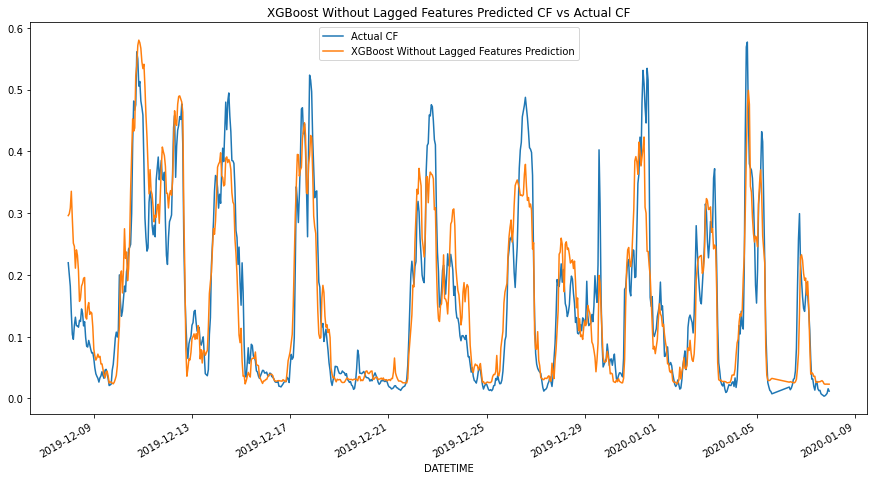

In [174]:
pd.DataFrame({'Actual CF':y_test0, 'XGBoost Without Lagged Features Prediction':y_pred_xgb0_test_plt}).plot(figsize=(15,8))
plt.title('XGBoost Without Lagged Features Predicted CF vs Actual CF')
plt.show()

### Predict on predict set (second tab in original Excel)

In [175]:
# feature engineering 
def get_final_predict_xgb(data, correlation):
    
    # Select wind speed features with top 80 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:80]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Generate categorical features and apply oneHotEncoder
    data_final['SEASON_Fall'] = data_final.index.month.isin([9,10,11]).astype(int)
    data_final['SEASON_Summer'] = data_final.index.month.isin([6,7,8]).astype(int)
    data_final['SEASON_Winter'] = data_final.index.month.isin([12,1,2]).astype(int)
    data_final['DAY_PART_Afternoon'] = data_final.index.hour.isin(range(12,18)).astype(int)
    data_final['DAY_PART_Midday'] = data_final.index.hour.isin(range(6,12)).astype(int)
    data_final['DAY_PART_Morning'] = data_final.index.hour.isin(range(0,6)).astype(int)
    data_final['DAY_PART_Night'] = data_final.index.hour.isin(range(18,24)).astype(int)
        
    return data_final

predict_final_xgb0 = get_final_predict_xgb(predict, pearson_spearman)

In [176]:
predict_final_xgb0.shape

(93, 97)

In [177]:
X_predict = predict_final_xgb0.drop(columns = ['CF'])

In [178]:
y_pred_xgb0 = best_xgb_model0.predict(X_predict)

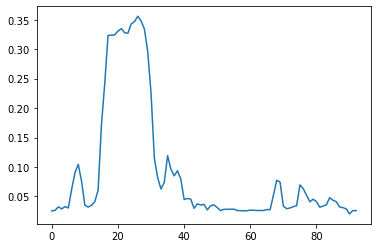

In [179]:
plt.plot(y_pred_xgb0)

# Model2: XGBoost with Lagged Features

### 1. Check Performance

Divide data into three parts:
- Training Set: data.iloc[:-104-24, :], used for training dataset
- One-day Gap: data.iloc[-104-24:-104, :], used to simulate the one-day(Jan 8th) gap
- Testing Set: data.iloc[-104:, :], used for testing dataset

In [180]:
# Test Set Starts from 2020-01-03 00:00:00
data_for_test = data.iloc[-93:, :].copy()
data_for_train = data.iloc[:-93-24, :].copy()
data_for_train.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-02 06:00:00  0.130273        1.85        1.78        4.90        2.80   
2020-01-02 07:00:00  0.134968        2.09        1.93        4.33        4.49   
2020-01-02 08:00:00  0.128623        2.09        1.90        4.05        4.31   
2020-01-02 09:00:00  0.123136        1.47        1.13        4.01        3.47   
2020-01-02 10:00:00  0.106036        1.82        1.51        4.79        3.14   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 06:00:00        2.97        1.51        1.75        1.31   
2020-01-02 07:00:00        3.77        2.23        3.49        1.34   
2020-01-02 08:00:00        2.84        2.07        2.41        1.80   
2020-01-02 09:00:00        2.18        1.30        1.52        1.51   
2020-01-02 10:00:00        2.18        0.92        1.70        1.64   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 06:00:00        3.34        2.91        2.50        1.44   
2020-01-02 07:00:00        3.96        3.68        2.64        1.17   
2020-01-02 08:00:00        3.36        2.75        2.65        1.42   
2020-01-02 09:00:00        1.87        2.13        2.13        1.20   
2020-01-02 10:00:00        2.11        2.12        2.57        1.71   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-02 06:00:00        3.60        1.87        6.13        6.08   
2020-01-02 07:00:00        4.37        2.53        5.55        5.53   
2020-01-02 08:00:00        3.54        2.66        5.43        5.41   
2020-01-02 09:00:00        2.97        2.04        5.47        5.47   
2020-01-02 10:00:00        1.65        1.85        5.59        5.59   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-02 06:00:00        1.44        5.82        2.23        1.71   
2020-01-02 07:00:00        2.36        5.59        2.82        1.04   
2020-01-02 08:00:00        2.04        5.30        2.83        1.30   
2020-01-02 09:00:00        1.52        5.15        2.32        1.02   
2020-01-02 10:00:00        1.02        4.71        2.07        0.80   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-02 06:00:00        2.50        1.61        4.78        4.70   
2020-01-02 07:00:00        2.66        0.94        3.71        4.85   
2020-01-02 08:00:00        1.57        1.24        4.69        5.00   
2020-01-02 09:00:00        1.68        1.01        5.12        4.61   
2020-01-02 10:00:00        2.06        0.80        4.20        4.28   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-02 06:00:00        1.99        1.72        4.93        4.28   
2020-01-02 07:00:00        1.90        1.17        6.21        5.01   
2020-01-02 08:00:00        1.70        1.27        5.47        4.80   
2020-01-02 09:00:00        2.26        1.52        4.54        4.44   
2020-01-02 10:00:00        2.17        1.20        5.50        5.14   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-02 06:00:00       11.90        1.53        3.09        1.74   
2020-01-02 07:00:00       12.79        1.60        4.14        2.72   
2020-01-02 08:00:00       14.07        1.65        4.54        3.36   
2020-01-02 09:00:00       16.03        1.07        4.27        3.07   
2020-01-02 10:00:00       17.85        1.61  

In [181]:
# feature engineering
def get_final_data_xgb1(data, correlation):
    
    # Select wind speed features with top 20 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:20]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)

    # Generate categorical features and apply oneHotEncoder
    categorical_columns = ['SEASON', 'DAY_PART']
    temp = data[categorical_columns].copy()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(temp)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df.index = data_final.index
    data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)

    data_final = data_final.dropna()
    
    return data_final

data_final_xgb1 = get_final_data_xgb1(data_for_train, pearson_spearman)
data_final_xgb1.tail()

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                      
2020-01-02 06:00:00  0.130273        5.42        6.61        6.63      6.63   
2020-01-02 07:00:00  0.134968        5.53        6.90        6.80      6.80   
2020-01-02 08:00:00  0.128623        4.25        6.41        6.36      6.36   
2020-01-02 09:00:00  0.123136        3.58        4.95        4.62      4.62   
2020-01-02 10:00:00  0.106036        2.74        4.49        4.05      4.05   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-02 06:00:00      6.51      6.57      6.45       6.64        6.66   
2020-01-02 07:00:00      6.71      6.68      6.63       6.64        6.54   
2020-01-02 08:00:00      5.92      5.98      5.63       6.36        6.28   
2020-01-02 09:00:00      4.12      4.33      4.02       5.15        5.17   
2020-01-02 10:00:00      3.47      3.62      3.32       4.56        4.43   

                     WS_74022  WS_73494  WS_883683  WS_75933  WS_76888  \
DATETIME                                                                 
2020-01-02 06:00:00      6.57      6.55       6.42      6.62      6.50   
2020-01-02 07:00:00      6.76      6.70       6.51      6.42      6.43   
2020-01-02 08:00:00      6.42      6.37       5.49      6.21      6.16   
2020-01-02 09:00:00      5.94      5.93       3.90      5.43      5.74   
2020-01-02 10:00:00      5.60      5.61       3.18      4.85      5.42   

                     WS_75287  WS_72733  WS_746023  WS_918665  WS_73822  \
DATETIME                                                                  
2020-01-02 06:00:00      6.52      6.60       6.60       6.61      6.57   
2020-01-02 07:00:00      6.38      6.37       6.35       6.42      6.37   
2020-01-02 08:00:00      6.16      6.18       6.15       5.97      5.90   
2020-01-02 09:00:00      5.65      5.53       5.53       5.02      4.96   
2020-01-02 10:00:00      5.28      5.02       4.98       4.11      4.07   

                     WS_73450  MIN_WS  MEDIAN_WS   P5_WS  P25_WS  P75_WS  \
DATETIME                                                                   
2020-01-02 06:00:00      6.51    0.70      3.615  1.4400  1.9075  6.3050   
2020-01-02 07:00:00      6.14    0.70      4.430  1.4225  2.5250  6.1325   
2020-01-02 08:00:00      5.96    0.90      4.105  1.5865  2.5400  5.6325   
2020-01-02 09:00:00      5.61    0.92      3.825  1.0565  1.9175  5.1550   
2020-01-02 10:00:00      5.19    0.80      3.470  1.2110  2.0450  4.9575   

                     P95_WS  MAX_WS   MEAN_WS    STD_WS   CF_lag1  \
DATETIME                                                            
2020-01-02 06:00:00  6.6300   11.90  4.096339  2.253986  0.115293   
2020-01-02 07:00:00  6.7780   12.79  4.416696  2.096632  0.130273   
2020-01-02 08:00:00  6.3645   14.07  4.178036  2.043768  0.134968   
2020-01-02 09:00:00  5.8585   16.03  3.675893  2.169267  0.128623   
2020-01-02 10:00:00  5.6280   17.85  3.660179  2.217925  0.123136   

                     WS_2503597_lag1  WS_2508550_lag1  WS_2508545_lag1  \
DATETIME                                                                 
2020-01-02 06:00:00             5.31             6.74             6.70   
2020-01-02 07:00:00             5.42             6.61             6.63   
2020-01-02 08:00:00             5.53             6.90             6.80   
2020-01-02 09:00:00             4.25             6.41             6.36   
2020-01-02 10:00:00             3.58             4.95             4.62   

                     WS_75936_lag1  WS_75935_lag1  WS_75934_lag1  \
DATETIME                                                           
2020-01-02 06:00:00           6.71           6.41           6.51   
2020-01-02 07:00:00           6.63           6.51           6.57   
2020-01-02 08:00:00           6.80           6.71           6.68   
2020-01-02 09:00:00

In [182]:
data_final_xgb1.shape

(3513, 100)

##### Modeling

In [183]:
X_train1, y_train1 = data_final_xgb1.drop(columns=['CF']), data_final_xgb1['CF']

In [184]:
# XGBoost Modeling
xgb_model1 = xgb.XGBRegressor(random_state=42)

param_grid_xgb1 = {
    'n_estimators': [600, 700],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.005, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

tscv1 = TimeSeriesSplit(n_splits=5)

grid_search_xgb1 = GridSearchCV(estimator=xgb_model1, param_grid=param_grid_xgb1, cv=tscv1, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_xgb1.fit(X_train1, y_train1)

best_xgb_model1 = grid_search_xgb1.best_estimator_
best_xgb_params1 = grid_search_xgb1.best_params_
best_xgb_score1 = -grid_search_xgb1.best_score_

print("Best parameters found: ", best_xgb_params1)
print("Best mean absolute error: ", best_xgb_score1)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 1.0}
Best mean absolute error:  0.022585495686267786


##### Fill Jan 2nd by using model prediction

In [185]:
# Extract Jan-2nd to simulate one-day(Jan 8th) gap
jan2_orginal = pd.DataFrame(columns = data.columns[:113], index=data_final_xgb1.index[-24:] + timedelta(days=1))
jan2_orginal.head()

CF WS_1133733 WS_1156770 WS_1156968 WS_1182195  \
DATETIME                                                               
2020-01-02 11:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00  NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00  NaN        NaN        NaN        NaN        NaN   

                    WS_1193865 WS_1321569 WS_1324653 WS_1358699 WS_1366338  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1366351 WS_1369320 WS_1461024 WS_1481513 WS_1504146  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1513782 WS_1513805 WS_1571308 WS_1574484 WS_1625339  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1625374 WS_1628663 WS_1681085 WS_1820276 WS_1820279  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1899876 WS_1911282 WS_1937650 WS_1937653 WS_1953863  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_1960535 WS_2113254 WS_2113394 WS_2118117 WS_2217107  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 12:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 13:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 14:00:00        NaN        NaN        NaN        NaN        NaN   
2020-01-02 15:00:00        NaN        NaN        NaN        NaN        NaN   

                    WS_2379547 WS_2385763 WS_2455069 WS_2460378 WS_2467589  \
DATETIME                                                                     
2020-01-02 11:00:00        NaN        NaN        NaN        NaN        NaN   
2

In [186]:
def create_features(series, lag_features):
    df = series.to_frame()
    col_name = df.columns[0]
    for lag in lag_features:
        df[f'lag_{lag}'] = df[col_name].shift(lag)
     
    df.dropna(inplace=True)
    return df
lag_features = list(np.arange(1,48,1)) + [24*3, 24*4, 24*5, 24*6, 24*7, 24*8, 24*9, 24*10]  # Lag features for past 1, 3, and 5 time steps

In [187]:
import lightgbm as lgb

for i, col_name in enumerate(jan2_orginal.columns[1:]):
    location_WS = create_features(data_for_train[col_name], lag_features)
    test_split_2 = round(len(location_WS)*0.20)
    train_data, test_data = location_WS[:-test_split_2], location_WS[-test_split_2:]
    X_train, y_train = train_data.drop(columns=[col_name]), train_data[col_name]
    X_test, y_test = test_data.drop(columns=[col_name]), test_data[col_name]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    
    # Fill
    for i in np.arange(1,25,1):
        temp = [np.nan] + [location_WS.iloc[-lag,0] for lag in lag_features]
        
        location_WS.loc[location_WS.index[-1] + timedelta(hours=1)] = temp
        location_WS.iloc[-1,0] = model.predict(np.array(temp[1:]).reshape(1,-1))
    
    jan2_orginal[col_name] = location_WS.iloc[-24:,0]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 4.693106
Mean Absolute Error: 0.44936026913674226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 4.104849
Mean Absolute Error: 0.44700013949885087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data poin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 4.161337
Mean Absolute Error: 0.5617681486332315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 4.796449
Mean Absolute Error: 0.4877926820417798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 6.297227
Mean Absolute Error: 0.6130720122589015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 6.326703
Mean Absolute Error: 0.6126505183015818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 5.248387
Mean Absolute Error: 0.5710425975770304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 4.665294
Mean Absolute Error: 0.4647454342826264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 5.208635
Mean Absolute Error: 0.5331002326731131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 6.088139
Mean Absolute Error: 0.5703415450378938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 5.593616
Mean Absolute Error: 0.5815570736824065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2622, number of used features: 55
[LightGBM] [Info] Start training from score 5.291916
Mean Absolute Error: 0.5573247339366074


Now dataset jan2_orginal is in the form of original dataset with 112 features

In [188]:
jan2_orginal

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-02 11:00:00  NaN    1.961589    1.520309    4.967935    2.951502   
2020-01-02 12:00:00  NaN    2.045710    1.579851    5.323389    2.914619   
2020-01-02 13:00:00  NaN    2.030424    1.697205    5.558289    2.805012   
2020-01-02 14:00:00  NaN    1.996854    1.572048    5.886345    2.809549   
2020-01-02 15:00:00  NaN    2.019639    1.432831    6.195794    2.729477   
2020-01-02 16:00:00  NaN    2.051524    1.532055    6.448857    2.465049   
2020-01-02 17:00:00  NaN    2.005356    1.568512    6.495205    2.189523   
2020-01-02 18:00:00  NaN    2.048389    1.655480    6.541077    1.998007   
2020-01-02 19:00:00  NaN    1.990849    1.645076    6.606366    1.973842   
2020-01-02 20:00:00  NaN    1.965594    1.552809    6.559167    2.182664   
2020-01-02 21:00:00  NaN    1.993883    1.381349    6.370864    2.177735   
2020-01-02 22:00:00  NaN    1.918896    1.309843    5.956121    1.975020   
2020-01-02 23:00:00  NaN    1.798982    1.356437    5.279294    2.056811   
2020-01-03 00:00:00  NaN    1.946640    1.617082    4.591449    2.149938   
2020-01-03 01:00:00  NaN    2.016858    1.863568    4.244009    2.157116   
2020-01-03 02:00:00  NaN    2.072735    1.879241    4.134982    2.230481   
2020-01-03 03:00:00  NaN    2.129850    1.887700    4.197925    2.498141   
2020-01-03 04:00:00  NaN    2.205300    1.876085    4.182253    2.704969   
2020-01-03 05:00:00  NaN    2.276035    1.887093    4.071708    2.883271   
2020-01-03 06:00:00  NaN    2.255274    1.886885    3.836374    3.036366   
2020-01-03 07:00:00  NaN    2.299631    1.849627    3.635296    2.976251   
2020-01-03 08:00:00  NaN    2.205182    1.659946    3.429252    2.857909   
2020-01-03 09:00:00  NaN    2.185761    1.586302    3.455364    2.519278   
2020-01-03 10:00:00  NaN    2.322259    1.629830    3.324726    2.231706   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 11:00:00    1.942484    1.371276    1.818902    1.917672   
2020-01-02 12:00:00    1.779344    1.540143    1.902329    2.409774   
2020-01-02 13:00:00    1.608676    1.572049    1.911717    3.100497   
2020-01-02 14:00:00    1.508207    1.663767    1.949065    3.721730   
2020-01-02 15:00:00    1.567077    1.936681    2.053920    4.198931   
2020-01-02 16:00:00    1.689135    1.948520    2.038999    4.558189   
2020-01-02 17:00:00    2.100713    1.736087    1.973154    5.047808   
2020-01-02 18:00:00    2.511871    1.511461    2.040675    5.911722   
2020-01-02 19:00:00    2.330143    1.620334    2.148317    7.333719   
2020-01-02 20:00:00    2.249151    1.605107    2.110812    9.127207   
2020-01-02 21:00:00    2.187557    1.863825    2.027804   11.492584   
2020-01-02 22:00:00    2.138306    1.929425    1.817043   13.587122   
2020-01-02 23:00:00    1.950703    2.218543    1.759217   16.507878   
2020-01-03 00:00:00    1.818501    2.263007    1.717167   17.304909   
2020-01-03 01:00:00    1.759770    2.157539    1.680575   17.463763   
2020-01-03 02:00:00    1.732737    2.161741    1.651501   17.281744   
2020-01-03 03:00:00    1.888109    1.969903    1.735359   17.281744   
2020-01-03 04:00:00    2.019333    1.760017    1.685526   17.140685   
2020-01-03 05:00:00    2.209875    1.540772    1.873664   17.140685   
2020-01-03 06:00:00    2.325409    1.501986    2.059830   15.848636   
2020-01-03 07:00:00    2.420307    1.853982    2.012819   15.815672   
2020-01-03 08:00:00    2.323663    1.803908    1.827678   16.053390   
2020-01-03 09:00:00    2.169768    1.672553    1.640991   15.370104   
2020-01-03 10:00:00    1.963845    1.542016    1.699538   14.069142   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 11:00:00    2.275972    1.999734    2.400412 

##### Preparation data for XGBoost to generate CF

In [189]:
jan2_orginal = generate_percentiles(jan2_orginal)
jan2_orginal = get_new_features(jan2_orginal)
jan2_orginal

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MIN_WS'] = data[ws_columns].min(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-02 11:00:00  NaN    1.961589    1.520309    4.967935    2.951502   
2020-01-02 12:00:00  NaN    2.045710    1.579851    5.323389    2.914619   
2020-01-02 13:00:00  NaN    2.030424    1.697205    5.558289    2.805012   
2020-01-02 14:00:00  NaN    1.996854    1.572048    5.886345    2.809549   
2020-01-02 15:00:00  NaN    2.019639    1.432831    6.195794    2.729477   
2020-01-02 16:00:00  NaN    2.051524    1.532055    6.448857    2.465049   
2020-01-02 17:00:00  NaN    2.005356    1.568512    6.495205    2.189523   
2020-01-02 18:00:00  NaN    2.048389    1.655480    6.541077    1.998007   
2020-01-02 19:00:00  NaN    1.990849    1.645076    6.606366    1.973842   
2020-01-02 20:00:00  NaN    1.965594    1.552809    6.559167    2.182664   
2020-01-02 21:00:00  NaN    1.993883    1.381349    6.370864    2.177735   
2020-01-02 22:00:00  NaN    1.918896    1.309843    5.956121    1.975020   
2020-01-02 23:00:00  NaN    1.798982    1.356437    5.279294    2.056811   
2020-01-03 00:00:00  NaN    1.946640    1.617082    4.591449    2.149938   
2020-01-03 01:00:00  NaN    2.016858    1.863568    4.244009    2.157116   
2020-01-03 02:00:00  NaN    2.072735    1.879241    4.134982    2.230481   
2020-01-03 03:00:00  NaN    2.129850    1.887700    4.197925    2.498141   
2020-01-03 04:00:00  NaN    2.205300    1.876085    4.182253    2.704969   
2020-01-03 05:00:00  NaN    2.276035    1.887093    4.071708    2.883271   
2020-01-03 06:00:00  NaN    2.255274    1.886885    3.836374    3.036366   
2020-01-03 07:00:00  NaN    2.299631    1.849627    3.635296    2.976251   
2020-01-03 08:00:00  NaN    2.205182    1.659946    3.429252    2.857909   
2020-01-03 09:00:00  NaN    2.185761    1.586302    3.455364    2.519278   
2020-01-03 10:00:00  NaN    2.322259    1.629830    3.324726    2.231706   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 11:00:00    1.942484    1.371276    1.818902    1.917672   
2020-01-02 12:00:00    1.779344    1.540143    1.902329    2.409774   
2020-01-02 13:00:00    1.608676    1.572049    1.911717    3.100497   
2020-01-02 14:00:00    1.508207    1.663767    1.949065    3.721730   
2020-01-02 15:00:00    1.567077    1.936681    2.053920    4.198931   
2020-01-02 16:00:00    1.689135    1.948520    2.038999    4.558189   
2020-01-02 17:00:00    2.100713    1.736087    1.973154    5.047808   
2020-01-02 18:00:00    2.511871    1.511461    2.040675    5.911722   
2020-01-02 19:00:00    2.330143    1.620334    2.148317    7.333719   
2020-01-02 20:00:00    2.249151    1.605107    2.110812    9.127207   
2020-01-02 21:00:00    2.187557    1.863825    2.027804   11.492584   
2020-01-02 22:00:00    2.138306    1.929425    1.817043   13.587122   
2020-01-02 23:00:00    1.950703    2.218543    1.759217   16.507878   
2020-01-03 00:00:00    1.818501    2.263007    1.717167   17.304909   
2020-01-03 01:00:00    1.759770    2.157539    1.680575   17.463763   
2020-01-03 02:00:00    1.732737    2.161741    1.651501   17.281744   
2020-01-03 03:00:00    1.888109    1.969903    1.735359   17.281744   
2020-01-03 04:00:00    2.019333    1.760017    1.685526   17.140685   
2020-01-03 05:00:00    2.209875    1.540772    1.873664   17.140685   
2020-01-03 06:00:00    2.325409    1.501986    2.059830   15.848636   
2020-01-03 07:00:00    2.420307    1.853982    2.012819   15.815672   
2020-01-03 08:00:00    2.323663    1.803908    1.827678   16.053390   
2020-01-03 09:00:00    2.169768    1.672553    1.640991   15.370104   
2020-01-03 10:00:00    1.963845    1.542016    1.699538   14.069142   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 11:00:00    2.275972    1.999734    2.400412 

In [190]:
jan2 = jan2_orginal.copy()
jan2.shape

(24, 131)

In [191]:
data_tail1 = data_for_train.iloc[-5:,]
data_with_jan2 = pd.concat([data_tail1, jan2])
data_with_jan2.shape

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\3702609650.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_jan2 = pd.concat([data_tail1, jan2])


(29, 131)

In [192]:
def get_final_jan8_xgb(data, correlation):
    # Select wind speed features with top 10 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:20]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)
    
    # Generate categorical features
    data_final['SEASON_Fall'] = data['MONTH'].isin([9, 10, 11]).astype(int)
    data_final['SEASON_Summer'] = data['MONTH'].isin([6, 7, 8]).astype(int)
    data_final['SEASON_Winter'] = data['MONTH'].isin([12, 1, 2]).astype(int)
        
    data_final['DAY_PART_Afternoon'] = data['DAY_PART'].isin(['Afternoon']).astype(int)
    data_final['DAY_PART_Midday'] = data['DAY_PART'].isin(['Midday']).astype(int)
    data_final['DAY_PART_Morning'] = data['DAY_PART'].isin(['Morning']).astype(int)
    data_final['DAY_PART_Night'] = data['DAY_PART'].isin(['Night']).astype(int)
        
    return data_final

In [193]:
data_final_jan2_xgb = get_final_jan8_xgb(data_with_jan2, pearson_spearman)
data_final_jan2_xgb = data_final_jan2_xgb.iloc[5:]
data_final_jan2_xgb

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                
2020-01-02 11:00:00 NaN    2.432059    3.976729    3.572593  3.724173   
2020-01-02 12:00:00 NaN    2.276912    3.207879    3.262444  3.661459   
2020-01-02 13:00:00 NaN    2.285859    2.677875    2.979252  3.377989   
2020-01-02 14:00:00 NaN    2.468832    2.295749    2.731797  3.259405   
2020-01-02 15:00:00 NaN    2.612739    2.256269    2.767781  3.095165   
2020-01-02 16:00:00 NaN    2.788122    2.219453    2.787299  2.860475   
2020-01-02 17:00:00 NaN    2.634152    2.137467    2.817737  2.611077   
2020-01-02 18:00:00 NaN    2.572563    2.295885    2.829969  2.332013   
2020-01-02 19:00:00 NaN    2.731694    2.462115    2.944786  2.416139   
2020-01-02 20:00:00 NaN    2.828746    2.555127    3.362551  2.718849   
2020-01-02 21:00:00 NaN    2.857029    3.005631    3.877465  3.268916   
2020-01-02 22:00:00 NaN    2.596406    3.539877    4.174936  3.894943   
2020-01-02 23:00:00 NaN    2.279040    3.657527    4.169982  4.038214   
2020-01-03 00:00:00 NaN    2.128712    3.561066    3.774487  3.955866   
2020-01-03 01:00:00 NaN    1.972378    3.370797    3.622042  3.796169   
2020-01-03 02:00:00 NaN    1.920532    3.327347    3.454559  3.767412   
2020-01-03 03:00:00 NaN    2.033330    3.435380    3.354284  3.654386   
2020-01-03 04:00:00 NaN    2.282239    3.712305    3.390634  3.674348   
2020-01-03 05:00:00 NaN    2.802702    4.240021    3.451801  3.824207   
2020-01-03 06:00:00 NaN    3.356979    4.525989    3.648476  4.022784   
2020-01-03 07:00:00 NaN    3.888948    4.609081    3.613174  4.077901   
2020-01-03 08:00:00 NaN    4.164765    4.533210    3.435550  3.975115   
2020-01-03 09:00:00 NaN    4.453981    4.346643    3.481986  3.814245   
2020-01-03 10:00:00 NaN    4.423878    4.071331    3.788396  3.715294   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-02 11:00:00  3.108360  3.547151  2.966269   4.212635    4.052303   
2020-01-02 12:00:00  2.676400  3.372688  2.561423   3.907126    3.670887   
2020-01-02 13:00:00  2.178267  3.244523  2.441538   3.733505    3.619032   
2020-01-02 14:00:00  2.004790  3.307240  2.473230   3.581881    3.923903   
2020-01-02 15:00:00  2.219640  3.531900  2.744528   3.530143    4.247621   
2020-01-02 16:00:00  2.421270  3.901301  2.737051   3.295148    4.268378   
2020-01-02 17:00:00  2.905592  3.997273  2.554365   3.085251    4.121569   
2020-01-02 18:00:00  3.367890  3.947471  2.510753   2.887528    3.785059   
2020-01-02 19:00:00  3.871779  3.734490  2.516147   2.524027    3.438326   
2020-01-02 20:00:00  4.163040  3.440982  2.679044   2.683657    3.228751   
2020-01-02 21:00:00  4.391125  3.502842  2.925390   2.880410    3.205651   
2020-01-02 22:00:00  4.120327  3.581569  3.048854   2.769204    3.253639   
2020-01-02 23:00:00  3.867252  3.713945  3.373673   2.731102    3.584847   
2020-01-03 00:00:00  3.570780  3.944204  3.510360   2.825869    4.109824   
2020-01-03 01:00:00  3.244963  3.655253  3.558289   2.880169    4.527944   
2020-01-03 02:00:00  3.114640  3.674134  3.697054   2.874464    4.968127   
2020-01-03 03:00:00  2.745028  3.617990  3.591521   2.789382    5.574920   
2020-01-03 04:00:00  2.458622  3.551172  3.698690   2.732860    5.897333   
2020-01-03 05:00:00  2.507627  3.623623  3.929856   2.655480    6.329365   
2020-01-03 06:00:00  2.489631  3.691760  3.758772   2.570014    6.484947   
2020-01-03 07:00:00  2.430157  3.804055  3.364799   2.467262    6.252605   
2020-01-03 08:00:00  2.397335  3.802377  3.161002   2.673055    6.160566   
2020-01-03 09:00:00  2.428011  3.832094  2.713723   2.788877    6.112279   
2020-01-03 10:00:00  2.436961  3.710259  2.373509   2.625436    6.124829   

                     WS_74022  WS_73494  WS_883683  WS_75933  WS_76888  \
DATETIME                                                               

##### Generate CF for Jan 2nd

In [194]:
data_final_jan2_xgb.columns[[30, 51, 72]]

Index(['CF_lag1', 'CF_lag2', 'CF_lag5'], dtype='object')

In [195]:
# Predict one row at a time
for i in range(data_final_jan2_xgb.shape[0]):
    if data_final_jan2_xgb.iloc[i, 1:].isna().any():
        if np.isnan(data_final_jan2_xgb.iloc[i, 30]):
            data_final_jan2_xgb.iloc[i, 30] = data_final_jan2_xgb.iloc[i - 1, 0]
        if np.isnan(data_final_jan2_xgb.iloc[i, 51]):
            data_final_jan2_xgb.iloc[i, 51] = data_final_jan2_xgb.iloc[i - 2, 0]
        if np.isnan(data_final_jan2_xgb.iloc[i, 72]):
            data_final_jan2_xgb.iloc[i, 72] = data_final_jan2_xgb.iloc[i - 5, 0]
    
    features = data_final_jan2_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model1.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    data_final_jan2_xgb.iloc[i,0] = prediction[0]
    jan2.iloc[i,0] = prediction[0]

Prediction for row 0: 0.08820021152496338
Prediction for row 1: 0.08231877535581589
Prediction for row 2: 0.06923834979534149
Prediction for row 3: 0.0646689385175705
Prediction for row 4: 0.0652017816901207
Prediction for row 5: 0.06410790234804153
Prediction for row 6: 0.05831203982234001
Prediction for row 7: 0.05816124007105827
Prediction for row 8: 0.056539684534072876
Prediction for row 9: 0.056539684534072876
Prediction for row 10: 0.05582456290721893
Prediction for row 11: 0.05896449461579323
Prediction for row 12: 0.0597844198346138
Prediction for row 13: 0.05943143367767334
Prediction for row 14: 0.06424452364444733
Prediction for row 15: 0.06605956703424454
Prediction for row 16: 0.07322701066732407
Prediction for row 17: 0.07191812992095947
Prediction for row 18: 0.06854691356420517
Prediction for row 19: 0.06737514585256577
Prediction for row 20: 0.0704667866230011
Prediction for row 21: 0.06987497210502625
Prediction for row 22: 0.07199104875326157
Prediction for row 23: 

<AxesSubplot:xlabel='DATETIME'>

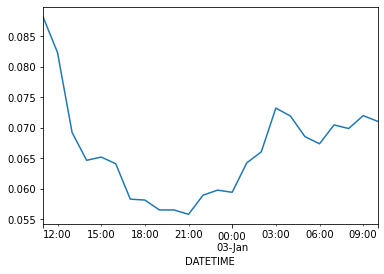

In [196]:
data_final_jan2_xgb['CF'].plot()

### Predict on the last 93 rows

In [197]:
# preparation for predict
data_tail1 = jan2.iloc[-5:,]
data_tail1.shape

(5, 131)

In [198]:
y_test1 = data_for_test['CF']
data_for_test['CF'] = np.nan

In [199]:
# predict
data_for_test = generate_percentiles(data_for_test)
data_for_test = get_new_features(data_for_test)
data_for_test.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-03 11:00:00 NaN        0.99        0.87        6.66        1.57   
2020-01-03 12:00:00 NaN        1.13        0.98        6.35        1.32   
2020-01-03 13:00:00 NaN        1.26        1.38        6.21        1.44   
2020-01-03 14:00:00 NaN        1.27        1.22        5.91        1.17   
2020-01-03 15:00:00 NaN        1.26        1.05        5.77        1.12   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-03 11:00:00        1.63        1.31        1.67        1.12   
2020-01-03 12:00:00        1.57        1.65        1.84        1.34   
2020-01-03 13:00:00        1.40        1.32        2.03        1.38   
2020-01-03 14:00:00        1.11        1.16        1.71        1.41   
2020-01-03 15:00:00        1.45        1.43        1.41        1.17   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-03 11:00:00        1.54        1.57        1.56        1.19   
2020-01-03 12:00:00        1.46        1.58        1.20        0.99   
2020-01-03 13:00:00        1.31        1.43        1.26        1.07   
2020-01-03 14:00:00        1.07        1.14        1.45        0.95   
2020-01-03 15:00:00        1.41        1.38        1.77        1.14   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-03 11:00:00        1.59        1.12        4.25        4.26   
2020-01-03 12:00:00        2.08        1.03        3.20        3.22   
2020-01-03 13:00:00        2.72        1.42        3.19        3.19   
2020-01-03 14:00:00        2.71        1.67        2.78        2.78   
2020-01-03 15:00:00        1.99        1.98        3.07        3.06   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-03 11:00:00        1.44        2.47        1.28        0.87   
2020-01-03 12:00:00        1.43        1.83        1.43        0.90   
2020-01-03 13:00:00        1.62        2.07        1.38        1.12   
2020-01-03 14:00:00        1.48        2.46        1.11        1.48   
2020-01-03 15:00:00        1.63        2.31        1.91        1.66   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-03 11:00:00        1.43        0.89        2.52        3.28   
2020-01-03 12:00:00        1.23        0.93        2.72        2.75   
2020-01-03 13:00:00        1.39        1.13        3.01        2.53   
2020-01-03 14:00:00        1.23        1.48        2.72        2.14   
2020-01-03 15:00:00        2.10        1.65        2.55        2.22   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-03 11:00:00        1.37        4.98        3.91        3.35   
2020-01-03 12:00:00        1.50        4.52        3.06        2.85   
2020-01-03 13:00:00        1.85        3.67        1.44        1.96   
2020-01-03 14:00:00        1.96        2.76        2.36        2.23   
2020-01-03 15:00:00        2.44        2.35        1.82        1.77   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-03 11:00:00       12.73        0.93        3.27        0.76   
2020-01-03 12:00:00       13.07        1.04        2.95        0.98   
2020-01-03 13:00:00       13.66        1.19        1.67        1.45   
2020-01-03 14:00:00       14.55        1.21        1.68        1.17   
2020-01-03 15:00:00       14.43        0.91        1.71        1.25   

         

In [200]:
jan2.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-02 11:00:00    0.0882    1.961589    1.520309    4.967935    2.951502   
2020-01-02 12:00:00  0.082319    2.045710    1.579851    5.323389    2.914619   
2020-01-02 13:00:00  0.069238    2.030424    1.697205    5.558289    2.805012   
2020-01-02 14:00:00  0.064669    1.996854    1.572048    5.886345    2.809549   
2020-01-02 15:00:00  0.065202    2.019639    1.432831    6.195794    2.729477   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-02 11:00:00    1.942484    1.371276    1.818902    1.917672   
2020-01-02 12:00:00    1.779344    1.540143    1.902329    2.409774   
2020-01-02 13:00:00    1.608676    1.572049    1.911717    3.100497   
2020-01-02 14:00:00    1.508207    1.663767    1.949065    3.721730   
2020-01-02 15:00:00    1.567077    1.936681    2.053920    4.198931   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-02 11:00:00    2.275972    1.999734    2.400412    1.830672   
2020-01-02 12:00:00    2.093914    1.896703    2.363236    1.490163   
2020-01-02 13:00:00    2.146851    1.708865    2.328543    1.342418   
2020-01-02 14:00:00    2.226256    1.683940    2.184284    1.425340   
2020-01-02 15:00:00    2.035433    1.651762    2.136055    1.611574   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-02 11:00:00    1.752812    1.763256    5.378367    5.409557   
2020-01-02 12:00:00    1.984056    1.618291    5.120923    5.157998   
2020-01-02 13:00:00    1.955509    1.564598    4.925187    4.816461   
2020-01-02 14:00:00    1.746288    1.631813    4.637028    4.547230   
2020-01-02 15:00:00    1.758756    1.823136    4.324546    4.247859   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-02 11:00:00    1.186990    4.568610    2.016377    1.235212   
2020-01-02 12:00:00    1.335823    4.155122    1.865417    1.766756   
2020-01-02 13:00:00    1.547490    3.665418    1.565291    2.467654   
2020-01-02 14:00:00    1.677695    3.139094    1.329599    2.795804   
2020-01-02 15:00:00    1.633675    2.791182    1.422049    3.049231   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-02 11:00:00    2.366213    1.254849    3.630225    4.091967   
2020-01-02 12:00:00    2.668735    1.913448    3.208945    3.708117   
2020-01-02 13:00:00    3.363621    2.672882    3.015978    3.265774   
2020-01-02 14:00:00    3.862797    3.381125    2.651012    2.815970   
2020-01-02 15:00:00    4.223960    3.340059    2.490569    2.551412   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-02 11:00:00    1.948661    1.783629    5.576324    5.071547   
2020-01-02 12:00:00    1.912436    2.555315    5.850564    4.693709   
2020-01-02 13:00:00    2.056463    3.395478    5.857680    4.621871   
2020-01-02 14:00:00    2.206619    3.927247    5.774473    4.493315   
2020-01-02 15:00:00    2.390826    4.453616    5.674892    4.472090   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-02 11:00:00   17.558164    1.476006    4.344605    2.686970   
2020-01-02 12:00:00   17.991518    1.527332    4.294762    2.447487   
2020-01-02 13:00:00   19.024388    1.701533    4.024560    2.159991   
2020-01-02 14:00:00   18.722569    1.632610    3.725921    1.933986   
2020-01-02 15:00:00   18.638728    1.743709  

In [201]:
full_df1 = pd.concat([data_tail1, data_for_test])
full_df1.shape

(98, 131)

In [202]:
def get_final_pred_data_xgb(data, correlation):
    # Select wind speed features with top 10 highest correlation with target value
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:20]['WS_location'].to_list()
    data_final = data[['CF']].copy()
    data_final = pd.concat([data_final, data[high_cor_list].copy()], axis=1)
    
    # Geneate aggregate statistics
    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)
    
    # Create lagged features
    columns_to_lag = [col for col in data_final.columns if col.startswith('WS_') or col == 'CF']
    lags = [1, 2, 5]

    for lag in lags:
        for col in columns_to_lag:
            data_final[f'{col}_lag{lag}'] = data_final[col].shift(lag)
    
    # Generate categorical features
    data_final['SEASON_Fall'] = data['MONTH'].isin([9, 10, 11]).astype(int)
    data_final['SEASON_Summer'] = data['MONTH'].isin([6, 7, 8]).astype(int)
    data_final['SEASON_Winter'] = data['MONTH'].isin([12, 1, 2]).astype(int)

    data_final['DAY_PART_Afternoon'] = data['DAY_PART'].isin(['Afternoon']).astype(int)
    data_final['DAY_PART_Midday'] = data['DAY_PART'].isin(['Midday']).astype(int)
    data_final['DAY_PART_Morning'] = data['DAY_PART'].isin(['Morning']).astype(int)
    data_final['DAY_PART_Night'] = data['DAY_PART'].isin(['Night']).astype(int)
            
    return data_final


In [203]:
predict_final_xgb1 = get_final_pred_data_xgb(full_df1, pearson_spearman)
predict_final_xgb1 = predict_final_xgb1.iloc[5:]
predict_final_xgb1

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                 
2020-01-03 11:00:00  NaN        3.00        3.84        3.89      3.89   
2020-01-03 12:00:00  NaN        2.81        4.12        4.04      4.04   
2020-01-03 13:00:00  NaN        2.43        3.75        3.88      3.89   
2020-01-03 14:00:00  NaN        1.26        2.97        3.09      3.09   
2020-01-03 15:00:00  NaN        1.33        2.78        2.94      2.94   
2020-01-03 16:00:00  NaN        1.36        2.52        2.65      2.65   
2020-01-03 17:00:00  NaN        1.27        2.39        2.43      2.43   
2020-01-03 18:00:00  NaN        1.88        2.46        2.49      2.49   
2020-01-03 19:00:00  NaN        1.30        1.37        1.45      1.45   
2020-01-03 20:00:00  NaN        1.31        1.53        1.59      1.59   
2020-01-03 21:00:00  NaN        1.45        1.63        1.69      1.69   
2020-01-03 22:00:00  NaN        1.45        1.56        1.64      1.64   
2020-01-03 23:00:00  NaN        1.47        1.34        1.38      1.38   
2020-01-04 00:00:00  NaN        1.12        1.15        1.29      1.29   
2020-01-04 01:00:00  NaN        0.89        0.70        0.77      0.77   
2020-01-04 02:00:00  NaN        0.77        0.76        0.68      0.68   
2020-01-04 03:00:00  NaN        0.81        0.84        0.76      0.76   
2020-01-04 04:00:00  NaN        0.75        0.78        0.70      0.70   
2020-01-04 05:00:00  NaN        1.26        1.39        1.29      1.29   
2020-01-04 06:00:00  NaN        1.47        2.43        2.24      2.23   
2020-01-04 07:00:00  NaN        1.96        3.35        3.32      3.32   
2020-01-04 08:00:00  NaN        2.28        3.77        3.71      3.71   
2020-01-04 09:00:00  NaN        2.21        3.84        3.77      3.77   
2020-01-04 10:00:00  NaN        1.83        3.64        3.37      3.37   
2020-01-04 11:00:00  NaN        2.68        4.23        3.91      3.91   
2020-01-04 12:00:00  NaN        4.18        5.17        4.85      4.85   
2020-01-04 13:00:00  NaN        6.12        7.19        6.72      6.70   
2020-01-04 14:00:00  NaN        9.34       10.51       10.27     10.27   
2020-01-04 15:00:00  NaN       12.27       12.63       12.43     12.43   
2020-01-04 16:00:00  NaN       13.83       14.10       13.86     13.86   
2020-01-04 17:00:00  NaN       13.02       14.49       14.21     14.21   
2020-01-04 18:00:00  NaN        9.94       13.82       13.40     13.40   
2020-01-04 19:00:00  NaN        9.10       12.78       12.38     12.38   
2020-01-04 20:00:00  NaN        8.38       11.47       11.04     11.04   
2020-01-04 21:00:00  NaN        8.02       11.15       10.80     10.80   
2020-01-04 22:00:00  NaN        7.97        9.10        8.72      8.72   
2020-01-04 23:00:00  NaN        7.78        8.05        7.52      7.52   
2020-01-05 00:00:00  NaN        9.20        8.40        8.05      8.05   
2020-01-05 01:00:00  NaN        8.82        8.49        8.02      8.02   
2020-01-05 02:00:00  NaN       10.19        9.31        9.01      9.01   
2020-01-05 03:00:00  NaN       11.25       10.79       10.65     10.65   
2020-01-05 04:00:00  NaN       11.62       11.83       11.82     11.82   
2020-01-05 05:00:00  NaN       11.14       12.51       12.55     12.55   
2020-01-05 06:00:00  NaN        9.99       12.16       12.28     12.28   
2020-01-05 07:00:00  NaN        9.60       12.25       12.23     12.23   
2020-01-05 08:00:00  NaN        7.10       10.23       10.26     10.26   
2020-01-05 09:00:00  NaN        3.90        6.94        7.11      7.10   
2020-01-05 10:00:00  NaN        2.71        4.65        4.93      4.93   
2020-01-05 11:00:00  NaN        2.48        2.30        2.64      2.64   
2020-01-05 12:00:00  NaN        3.07        3.11        3.06      3.06   
2020-01-05 13:00:00  NaN        2.62        2.79        2.77      2.77   
2020-01-05 14:00:00  NaN        2.37        2.63        2.59      2.59   
2020-01-05 15:00:00  NaN  

In [204]:
predict_final_xgb1.columns[[30, 51, 72]]

Index(['CF_lag1', 'CF_lag2', 'CF_lag5'], dtype='object')

In [205]:
# Predict one row at a time
for i in range(predict_final_xgb1.shape[0]):
    if predict_final_xgb1.iloc[i, 1:].isna().any():
        if np.isnan(predict_final_xgb1.iloc[i, 30]):
            predict_final_xgb1.iloc[i, 30] = predict_final_xgb1.iloc[i - 1, 0]
        if np.isnan(predict_final_xgb1.iloc[i, 51]):
            predict_final_xgb1.iloc[i, 51] = predict_final_xgb1.iloc[i - 2, 0]
        if np.isnan(predict_final_xgb1.iloc[i, 72]):
            predict_final_xgb1.iloc[i, 72] = predict_final_xgb1.iloc[i - 5, 0]
    
    features = predict_final_xgb1.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model1.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    predict_final_xgb1.iloc[i,0] = prediction[0]

Prediction for row 0: 0.05953724682331085
Prediction for row 1: 0.05541391670703888
Prediction for row 2: 0.05347299948334694
Prediction for row 3: 0.05313733592629433
Prediction for row 4: 0.05332225188612938
Prediction for row 5: 0.054485123604536057
Prediction for row 6: 0.05492059513926506
Prediction for row 7: 0.05486948788166046
Prediction for row 8: 0.055970847606658936
Prediction for row 9: 0.055970847606658936
Prediction for row 10: 0.055970847606658936
Prediction for row 11: 0.056275252252817154
Prediction for row 12: 0.055970847606658936
Prediction for row 13: 0.05646682530641556
Prediction for row 14: 0.05646682530641556
Prediction for row 15: 0.05646682530641556
Prediction for row 16: 0.05951869487762451
Prediction for row 17: 0.06298675388097763
Prediction for row 18: 0.06413605064153671
Prediction for row 19: 0.06662856042385101
Prediction for row 20: 0.07842806726694107
Prediction for row 21: 0.08451662212610245
Prediction for row 22: 0.0855678841471672
Prediction for r

In [206]:
y_pred_xgb1_test = predict_final_xgb1['CF']

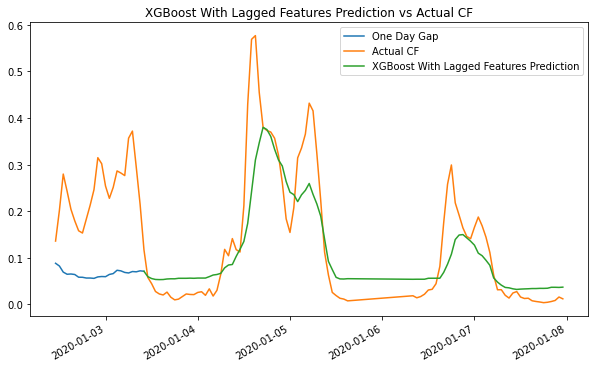

In [207]:
plt.figure(figsize=(10,6))
plt.title("XGBoost With Lagged Features Prediction vs Actual CF")
plt.plot(np.array(data_final_jan2_xgb['CF'].index), np.array(data_final_jan2_xgb['CF'].values), label='One Day Gap')
plt.plot(data[data.index >= datetime(2020,1,2,11,0,0)]['CF'], label='Actual CF')

plt.plot(np.append(np.array(data_final_jan2_xgb['CF'].index)[-1], np.array(y_pred_xgb1_test.index)), np.append(np.array(data_final_jan2_xgb['CF'].values)[-1], y_pred_xgb1_test.values), label='XGBoost With Lagged Features Prediction')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [228]:
mean_absolute_error(y_pred_xgb1_test, y_test1)

0.04980053250461166

## 2. Prediction on predict set (second tab in original excel)

### Fill Jan 8th by using model prediction

In [212]:
jan8_original = pd.DataFrame(columns = data.columns[:113], index=data.index[-24:] + timedelta(days=1))
jan8_original.shape

(24, 113)

In [213]:
import lightgbm as lgb

for i, col_name in enumerate(jan8_original.columns[1:]):
    location_WS = create_features(data[col_name], lag_features)
    test_split_2 = round(len(location_WS)*0.20)
    train_data, test_data = location_WS[:-test_split_2], location_WS[-test_split_2:]
    X_train, y_train = train_data.drop(columns=[col_name]), train_data[col_name]
    X_test, y_test = test_data.drop(columns=[col_name]), test_data[col_name]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    
    # Fill
    for i in np.arange(1,25,1):
        temp = [np.nan] + [location_WS.iloc[-lag,0] for lag in lag_features]
        
        location_WS.loc[location_WS.index[-1] + timedelta(hours=1)] = temp
        location_WS.iloc[-1,0] = model.predict(np.array(temp[1:]).reshape(1,-1))
    
    jan8_original[col_name] = location_WS.iloc[-24:,0]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 4.632498
Mean Absolute Error: 0.455803019288763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 4.047623
Mean Absolute Error: 0.4449121963877724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 4.149954
Mean Absolute Error: 0.5402885709089467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 4.815298
Mean Absolute Error: 0.4888282641413247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 6.324422
Mean Absolute Error: 0.6494434306333521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 6.357450
Mean Absolute Error: 0.6431262962553596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 5.223262
Mean Absolute Error: 0.5750263961552178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 4.599728
Mean Absolute Error: 0.4634871403619611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 5.162459
Mean Absolute Error: 0.5464632889429558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 6.131635
Mean Absolute Error: 0.6080057163125292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 5.629602
Mean Absolute Error: 0.5937464377753744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 55
[LightGBM] [Info] Start training from score 5.350013
Mean Absolute Error: 0.5283891044403863


Now dataset jan8_original is in the form of original dataset with 112 features

In [214]:
jan8_original

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-08 00:00:00  NaN    1.601821    2.037208    2.514424    1.640306   
2020-01-08 01:00:00  NaN    1.591990    2.173365    2.686191    1.838061   
2020-01-08 02:00:00  NaN    1.628812    2.168984    2.522127    2.066229   
2020-01-08 03:00:00  NaN    1.644075    2.228335    2.266159    2.515949   
2020-01-08 04:00:00  NaN    1.690573    2.241759    2.180672    3.093215   
2020-01-08 05:00:00  NaN    1.890058    2.235555    2.211238    3.624585   
2020-01-08 06:00:00  NaN    2.178810    2.222532    2.250866    4.228950   
2020-01-08 07:00:00  NaN    2.257832    2.219550    2.356681    4.709342   
2020-01-08 08:00:00  NaN    2.334099    2.217989    2.519404    5.289245   
2020-01-08 09:00:00  NaN    2.317759    2.192452    2.774095    5.563993   
2020-01-08 10:00:00  NaN    2.004115    2.107753    3.329175    6.010587   
2020-01-08 11:00:00  NaN    1.978607    2.238027    3.670930    6.110475   
2020-01-08 12:00:00  NaN    2.017751    2.332669    4.057690    6.145479   
2020-01-08 13:00:00  NaN    2.081038    2.429143    4.115671    6.053357   
2020-01-08 14:00:00  NaN    2.009097    2.104087    4.429721    6.043406   
2020-01-08 15:00:00  NaN    2.100365    1.817533    4.857036    5.817665   
2020-01-08 16:00:00  NaN    2.012876    1.709904    5.461300    5.512776   
2020-01-08 17:00:00  NaN    2.077365    1.583615    6.085925    5.293313   
2020-01-08 18:00:00  NaN    2.142606    1.522476    6.433840    4.889772   
2020-01-08 19:00:00  NaN    2.265294    1.490101    6.753557    4.461399   
2020-01-08 20:00:00  NaN    2.243773    1.485708    7.172546    3.882670   
2020-01-08 21:00:00  NaN    2.178664    1.410210    7.379700    3.182728   
2020-01-08 22:00:00  NaN    1.969328    1.577012    7.544650    2.561695   
2020-01-08 23:00:00  NaN    1.982261    1.728462    7.527285    2.351988   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 00:00:00    2.801882    1.208196    1.186273    2.964196   
2020-01-08 01:00:00    2.878375    1.435385    1.164815    2.801213   
2020-01-08 02:00:00    2.877589    1.440419    1.391754    2.790868   
2020-01-08 03:00:00    2.911913    1.431556    1.408626    2.691605   
2020-01-08 04:00:00    2.888129    1.732186    1.278181    2.824552   
2020-01-08 05:00:00    2.983861    1.702464    1.333466    2.919171   
2020-01-08 06:00:00    3.143867    1.631159    1.410149    3.206065   
2020-01-08 07:00:00    2.843132    1.676206    1.341752    3.547936   
2020-01-08 08:00:00    2.541597    1.434701    1.351798    3.844719   
2020-01-08 09:00:00    2.346060    1.453689    1.465429    3.963972   
2020-01-08 10:00:00    2.380343    1.560844    1.455142    3.798015   
2020-01-08 11:00:00    2.443351    1.945916    1.451910    3.574324   
2020-01-08 12:00:00    2.426403    1.991855    1.562883    3.166111   
2020-01-08 13:00:00    2.333308    1.928498    1.836796    2.890862   
2020-01-08 14:00:00    2.295438    1.790546    2.051697    2.585799   
2020-01-08 15:00:00    2.179747    1.544840    2.327433    2.358100   
2020-01-08 16:00:00    1.899573    1.597903    2.518770    2.156008   
2020-01-08 17:00:00    1.756072    1.680568    2.623175    2.078726   
2020-01-08 18:00:00    1.695348    1.763685    2.843595    1.981436   
2020-01-08 19:00:00    1.705059    1.634045    3.102831    1.968934   
2020-01-08 20:00:00    1.715968    1.391476    3.375378    1.954782   
2020-01-08 21:00:00    1.714476    1.259519    3.571897    2.131626   
2020-01-08 22:00:00    1.676929    1.351293    3.780532    2.498730   
2020-01-08 23:00:00    1.852146    1.231523    3.523058    3.007603   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 00:00:00    3.114131    2.532677    1.745500 

Preparation data for XGBoost to generate CF

In [215]:
jan8_original = generate_percentiles(jan8_original)
jan8_original = get_new_features(jan8_original)
jan8_original

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MIN_WS'] = data[ws_columns].min(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1685335405.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                   
2020-01-08 00:00:00  NaN    1.601821    2.037208    2.514424    1.640306   
2020-01-08 01:00:00  NaN    1.591990    2.173365    2.686191    1.838061   
2020-01-08 02:00:00  NaN    1.628812    2.168984    2.522127    2.066229   
2020-01-08 03:00:00  NaN    1.644075    2.228335    2.266159    2.515949   
2020-01-08 04:00:00  NaN    1.690573    2.241759    2.180672    3.093215   
2020-01-08 05:00:00  NaN    1.890058    2.235555    2.211238    3.624585   
2020-01-08 06:00:00  NaN    2.178810    2.222532    2.250866    4.228950   
2020-01-08 07:00:00  NaN    2.257832    2.219550    2.356681    4.709342   
2020-01-08 08:00:00  NaN    2.334099    2.217989    2.519404    5.289245   
2020-01-08 09:00:00  NaN    2.317759    2.192452    2.774095    5.563993   
2020-01-08 10:00:00  NaN    2.004115    2.107753    3.329175    6.010587   
2020-01-08 11:00:00  NaN    1.978607    2.238027    3.670930    6.110475   
2020-01-08 12:00:00  NaN    2.017751    2.332669    4.057690    6.145479   
2020-01-08 13:00:00  NaN    2.081038    2.429143    4.115671    6.053357   
2020-01-08 14:00:00  NaN    2.009097    2.104087    4.429721    6.043406   
2020-01-08 15:00:00  NaN    2.100365    1.817533    4.857036    5.817665   
2020-01-08 16:00:00  NaN    2.012876    1.709904    5.461300    5.512776   
2020-01-08 17:00:00  NaN    2.077365    1.583615    6.085925    5.293313   
2020-01-08 18:00:00  NaN    2.142606    1.522476    6.433840    4.889772   
2020-01-08 19:00:00  NaN    2.265294    1.490101    6.753557    4.461399   
2020-01-08 20:00:00  NaN    2.243773    1.485708    7.172546    3.882670   
2020-01-08 21:00:00  NaN    2.178664    1.410210    7.379700    3.182728   
2020-01-08 22:00:00  NaN    1.969328    1.577012    7.544650    2.561695   
2020-01-08 23:00:00  NaN    1.982261    1.728462    7.527285    2.351988   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 00:00:00    2.801882    1.208196    1.186273    2.964196   
2020-01-08 01:00:00    2.878375    1.435385    1.164815    2.801213   
2020-01-08 02:00:00    2.877589    1.440419    1.391754    2.790868   
2020-01-08 03:00:00    2.911913    1.431556    1.408626    2.691605   
2020-01-08 04:00:00    2.888129    1.732186    1.278181    2.824552   
2020-01-08 05:00:00    2.983861    1.702464    1.333466    2.919171   
2020-01-08 06:00:00    3.143867    1.631159    1.410149    3.206065   
2020-01-08 07:00:00    2.843132    1.676206    1.341752    3.547936   
2020-01-08 08:00:00    2.541597    1.434701    1.351798    3.844719   
2020-01-08 09:00:00    2.346060    1.453689    1.465429    3.963972   
2020-01-08 10:00:00    2.380343    1.560844    1.455142    3.798015   
2020-01-08 11:00:00    2.443351    1.945916    1.451910    3.574324   
2020-01-08 12:00:00    2.426403    1.991855    1.562883    3.166111   
2020-01-08 13:00:00    2.333308    1.928498    1.836796    2.890862   
2020-01-08 14:00:00    2.295438    1.790546    2.051697    2.585799   
2020-01-08 15:00:00    2.179747    1.544840    2.327433    2.358100   
2020-01-08 16:00:00    1.899573    1.597903    2.518770    2.156008   
2020-01-08 17:00:00    1.756072    1.680568    2.623175    2.078726   
2020-01-08 18:00:00    1.695348    1.763685    2.843595    1.981436   
2020-01-08 19:00:00    1.705059    1.634045    3.102831    1.968934   
2020-01-08 20:00:00    1.715968    1.391476    3.375378    1.954782   
2020-01-08 21:00:00    1.714476    1.259519    3.571897    2.131626   
2020-01-08 22:00:00    1.676929    1.351293    3.780532    2.498730   
2020-01-08 23:00:00    1.852146    1.231523    3.523058    3.007603   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 00:00:00    3.114131    2.532677    1.745500 

In [216]:
jan8 = jan8_original.copy()
jan8.shape

(24, 131)

In [217]:
data_tail2 = data.iloc[-5:,]
data_with_jan8 = pd.concat([data_tail2, jan8])
data_with_jan8.shape

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1261200511.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_jan8 = pd.concat([data_tail2, jan8])


(29, 131)

In [218]:
data_final_jan8_xgb = get_final_jan8_xgb(data_with_jan8, pearson_spearman)
data_final_jan8_xgb = data_final_jan8_xgb.iloc[5:]
data_final_jan8_xgb

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                
2020-01-08 00:00:00 NaN    1.275462    1.438626    1.271352  1.333364   
2020-01-08 01:00:00 NaN    1.428153    1.807741    1.448824  1.528727   
2020-01-08 02:00:00 NaN    1.966125    2.054621    1.605211  1.899660   
2020-01-08 03:00:00 NaN    2.526673    2.082832    1.924307  2.211296   
2020-01-08 04:00:00 NaN    3.154133    2.105169    2.319079  2.393391   
2020-01-08 05:00:00 NaN    3.669353    2.348286    2.900548  2.441308   
2020-01-08 06:00:00 NaN    4.478260    3.025813    3.415391  2.885334   
2020-01-08 07:00:00 NaN    5.092516    3.892159    4.252658  3.135798   
2020-01-08 08:00:00 NaN    5.378028    4.733852    5.152163  3.494030   
2020-01-08 09:00:00 NaN    5.634788    5.253839    5.384412  3.612901   
2020-01-08 10:00:00 NaN    5.804061    6.036311    5.426774  3.561257   
2020-01-08 11:00:00 NaN    5.807856    6.480702    5.493828  3.405542   
2020-01-08 12:00:00 NaN    5.965854    6.758748    5.624051  3.377840   
2020-01-08 13:00:00 NaN    6.225508    6.702603    5.433405  3.251661   
2020-01-08 14:00:00 NaN    6.520696    6.762629    5.446684  3.259408   
2020-01-08 15:00:00 NaN    6.980700    7.075157    5.611808  3.515861   
2020-01-08 16:00:00 NaN    7.616694    7.243403    5.666486  4.107393   
2020-01-08 17:00:00 NaN    8.490130    7.401939    5.796028  4.541940   
2020-01-08 18:00:00 NaN    8.940525    7.516977    6.137124  5.150916   
2020-01-08 19:00:00 NaN    9.249813    7.884107    6.616968  5.850343   
2020-01-08 20:00:00 NaN    9.360637    8.012426    6.835871  6.262971   
2020-01-08 21:00:00 NaN    9.259855    8.232458    6.968928  6.505357   
2020-01-08 22:00:00 NaN    9.064839    8.299800    7.258235  6.759888   
2020-01-08 23:00:00 NaN    8.756294    8.043191    7.567945  7.000655   

                     WS_75935  WS_75934  WS_77363  WS_631992  WS_2217107  \
DATETIME                                                                   
2020-01-08 00:00:00  1.426703  1.522851  1.379593   1.428491    1.589727   
2020-01-08 01:00:00  1.585067  1.800330  1.480278   1.719438    2.175853   
2020-01-08 02:00:00  1.668087  2.049828  1.440024   1.977016    2.180734   
2020-01-08 03:00:00  1.816294  2.094576  1.439261   1.918016    2.181573   
2020-01-08 04:00:00  2.271239  2.059907  1.465368   1.961282    2.060665   
2020-01-08 05:00:00  3.187399  2.211085  1.518674   2.015535    2.027909   
2020-01-08 06:00:00  4.188111  2.422557  1.849113   2.266384    2.174599   
2020-01-08 07:00:00  4.856873  2.700994  2.195749   2.561695    2.066843   
2020-01-08 08:00:00  4.809364  3.123775  2.290024   3.402469    2.143130   
2020-01-08 09:00:00  4.173721  3.433775  2.536928   4.625132    2.163324   
2020-01-08 10:00:00  3.322895  3.659440  2.996601   5.605748    2.350004   
2020-01-08 11:00:00  2.993689  3.662873  3.890933   6.374056    2.786099   
2020-01-08 12:00:00  3.087197  3.844577  4.519412   6.775373    3.325893   
2020-01-08 13:00:00  3.512279  3.876146  5.098734   7.148554    3.897053   
2020-01-08 14:00:00  4.049263  3.785331  5.159989   8.000874    4.323056   
2020-01-08 15:00:00  4.253400  3.896400  5.250414   8.378986    5.116607   
2020-01-08 16:00:00  4.478611  3.881486  5.095957   9.366812    5.573445   
2020-01-08 17:00:00  4.642267  3.869551  4.892214   9.891761    5.687092   
2020-01-08 18:00:00  4.856010  3.935638  4.999639  10.892222    6.208838   
2020-01-08 19:00:00  5.089657  4.118891  5.334132  11.952323    6.459032   
2020-01-08 20:00:00  5.206712  4.395879  5.642817  12.424190    6.789909   
2020-01-08 21:00:00  5.327077  4.979996  5.959564  13.109666    7.274314   
2020-01-08 22:00:00  5.538807  5.552688  6.032293  13.577590    7.894081   
2020-01-08 23:00:00  5.847871  6.121689  6.363029  13.858723    8.280906   

                     WS_74022   WS_73494  WS_883683  WS_75933  WS_76888  \
DATETIME                                                              

**Generate CF for Jan 8th**

In [219]:
data_final_jan8_xgb.columns[[30, 51, 72]]

Index(['CF_lag1', 'CF_lag2', 'CF_lag5'], dtype='object')

In [220]:
# Predict one row at a time
for i in range(data_final_jan8_xgb.shape[0]):
    if data_final_jan8_xgb.iloc[i, 1:].isna().any():
        if np.isnan(data_final_jan8_xgb.iloc[i, 30]):
            data_final_jan8_xgb.iloc[i, 30] = data_final_jan8_xgb.iloc[i - 1, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 51]):
            data_final_jan8_xgb.iloc[i, 51] = data_final_jan8_xgb.iloc[i - 2, 0]
        if np.isnan(data_final_jan8_xgb.iloc[i, 72]):
            data_final_jan8_xgb.iloc[i, 72] = data_final_jan8_xgb.iloc[i - 5, 0]
    
    features = data_final_jan8_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model1.predict(features)       
    print(f"Prediction for row {i}: {prediction[0]}")
    data_final_jan8_xgb.iloc[i,0] = prediction[0]
    jan8.iloc[i,0] = prediction[0]

Prediction for row 0: 0.019600193947553635
Prediction for row 1: 0.023461243137717247
Prediction for row 2: 0.025843974202871323
Prediction for row 3: 0.029482148587703705
Prediction for row 4: 0.030907711014151573
Prediction for row 5: 0.03278079628944397
Prediction for row 6: 0.03283696994185448
Prediction for row 7: 0.035786572843790054
Prediction for row 8: 0.039510175585746765
Prediction for row 9: 0.04068225249648094
Prediction for row 10: 0.040495842695236206
Prediction for row 11: 0.040495842695236206
Prediction for row 12: 0.04178492724895477
Prediction for row 13: 0.045013491064310074
Prediction for row 14: 0.048251036554574966
Prediction for row 15: 0.052575185894966125
Prediction for row 16: 0.06750188767910004
Prediction for row 17: 0.07858641445636749
Prediction for row 18: 0.08480237424373627
Prediction for row 19: 0.09583976119756699
Prediction for row 20: 0.11803475022315979
Prediction for row 21: 0.13659453392028809
Prediction for row 22: 0.15013910830020905
Predictio

<AxesSubplot:xlabel='DATETIME'>

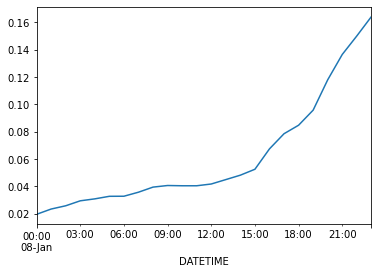

In [221]:
data_final_jan8_xgb['CF'].plot()

### Predict on the predict set

In [222]:
# preparation for predict
data_tail2 = jan8.iloc[-5:,]
data_tail2.shape

(5, 131)

In [223]:
full_df = pd.concat([data_tail2, predict])
full_df.shape

(98, 131)

In [224]:
full_df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-08 19:00:00   0.09584    2.265294    1.490101    6.753557    4.461399   
2020-01-08 20:00:00  0.118035    2.243773    1.485708    7.172546    3.882670   
2020-01-08 21:00:00  0.136595    2.178664    1.410210    7.379700    3.182728   
2020-01-08 22:00:00  0.150139    1.969328    1.577012    7.544650    2.561695   
2020-01-08 23:00:00  0.164265    1.982261    1.728462    7.527285    2.351988   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-08 19:00:00    1.705059    1.634045    3.102831    1.968934   
2020-01-08 20:00:00    1.715968    1.391476    3.375378    1.954782   
2020-01-08 21:00:00    1.714476    1.259519    3.571897    2.131626   
2020-01-08 22:00:00    1.676929    1.351293    3.780532    2.498730   
2020-01-08 23:00:00    1.852146    1.231523    3.523058    3.007603   

                     WS_1366338  WS_1366351  WS_1369320  WS_1461024  \
DATETIME                                                              
2020-01-08 19:00:00    1.819269    1.583081    3.482245    1.386184   
2020-01-08 20:00:00    1.652478    1.640444    3.348990    1.459738   
2020-01-08 21:00:00    1.417208    1.785611    2.982450    1.424916   
2020-01-08 22:00:00    1.372939    1.712431    2.696133    1.460331   
2020-01-08 23:00:00    1.590979    1.880928    2.686311    1.437292   

                     WS_1481513  WS_1504146  WS_1513782  WS_1513805  \
DATETIME                                                              
2020-01-08 19:00:00    1.885699    1.605582    3.806030    3.904230   
2020-01-08 20:00:00    1.893339    1.378763    3.825405    3.765153   
2020-01-08 21:00:00    1.951294    1.371903    3.854596    3.757297   
2020-01-08 22:00:00    1.938097    1.343187    3.913895    3.961535   
2020-01-08 23:00:00    1.871892    1.412019    3.979648    4.099226   

                     WS_1571308  WS_1574484  WS_1625339  WS_1625374  \
DATETIME                                                              
2020-01-08 19:00:00    1.716159    3.185176    1.488991    2.169965   
2020-01-08 20:00:00    1.802513    3.128335    1.495972    1.998933   
2020-01-08 21:00:00    1.948294    3.322141    1.444776    1.781993   
2020-01-08 22:00:00    2.099315    3.423487    1.465412    1.516392   
2020-01-08 23:00:00    2.147918    3.772945    1.633982    1.429473   

                     WS_1628663  WS_1681085  WS_1820276  WS_1820279  \
DATETIME                                                              
2020-01-08 19:00:00    1.951982    2.289749    1.669491    2.706647   
2020-01-08 20:00:00    2.090462    2.115098    1.591101    2.549638   
2020-01-08 21:00:00    2.178985    1.733002    1.499985    2.485104   
2020-01-08 22:00:00    2.280255    1.596220    1.599514    2.445514   
2020-01-08 23:00:00    2.530542    1.563646    1.451177    2.183940   

                     WS_1899876  WS_1911282  WS_1937650  WS_1937653  \
DATETIME                                                              
2020-01-08 19:00:00    1.937024    1.967822    3.024585    3.904082   
2020-01-08 20:00:00    1.792998    2.010501    2.821357    3.539281   
2020-01-08 21:00:00    1.672899    2.065671    2.898839    3.420247   
2020-01-08 22:00:00    1.624556    2.210052    2.735210    3.213033   
2020-01-08 23:00:00    1.673869    2.323382    2.489355    2.923233   

                     WS_1953863  WS_1960535  WS_2113254  WS_2113394  \
DATETIME                                                              
2020-01-08 19:00:00    7.224698    3.638019    4.493697    2.051886   
2020-01-08 20:00:00    7.579009    3.528107    4.500101    2.205865   
2020-01-08 21:00:00    7.952634    3.491418    4.548518    2.495763   
2020-01-08 22:00:00    8.392447    3.458290    4.489666    2.642816   
2020-01-08 23:00:00    8.515257    3.351062  

In [225]:
predict_final_xgb = get_final_pred_data_xgb(full_df, pearson_spearman)
predict_final_xgb = predict_final_xgb.iloc[5:]
predict_final_xgb

CF  WS_2503597  WS_2508550  WS_2508545  WS_75936  \
DATETIME                                                                 
2020-01-09 00:00:00  NaN        0.83        1.08        1.18      1.18   
2020-01-09 01:00:00  NaN        1.11        0.92        1.24      1.24   
2020-01-09 02:00:00  NaN        0.97        0.86        1.26      1.26   
2020-01-09 03:00:00  NaN        1.05        1.19        1.60      1.61   
2020-01-09 04:00:00  NaN        0.89        1.39        1.81      1.81   
2020-01-09 05:00:00  NaN        1.44        3.03        3.36      3.36   
2020-01-09 06:00:00  NaN        3.41        5.81        5.88      5.88   
2020-01-09 07:00:00  NaN        5.69        7.68        7.64      7.64   
2020-01-09 08:00:00  NaN        6.19        7.98        7.98      7.98   
2020-01-09 09:00:00  NaN        4.90        6.82        6.86      6.86   
2020-01-09 10:00:00  NaN        2.64        3.94        4.08      4.08   
2020-01-09 11:00:00  NaN        1.83        2.11        2.04      2.04   
2020-01-09 12:00:00  NaN        1.88        2.25        2.04      2.04   
2020-01-09 13:00:00  NaN        1.57        1.93        1.79      1.79   
2020-01-09 14:00:00  NaN        2.71        4.35        4.39      4.39   
2020-01-09 15:00:00  NaN        5.76        8.54        8.45      8.45   
2020-01-09 16:00:00  NaN       11.56       12.32       12.21     12.21   
2020-01-09 17:00:00  NaN       13.86       14.33       14.16     14.16   
2020-01-09 18:00:00  NaN       15.30       15.07       14.99     14.99   
2020-01-09 19:00:00  NaN       16.84       16.54       16.54     16.54   
2020-01-09 20:00:00  NaN       16.59       16.43       16.44     16.44   
2020-01-09 21:00:00  NaN       15.46       15.01       14.87     14.87   
2020-01-09 22:00:00  NaN       14.34       13.38       12.97     12.97   
2020-01-09 23:00:00  NaN       14.50       13.98       13.69     13.69   
2020-01-10 00:00:00  NaN       14.25       13.98       13.77     13.77   
2020-01-10 01:00:00  NaN       14.10       14.05       13.94     13.94   
2020-01-10 02:00:00  NaN       13.18       13.73       13.75     13.74   
2020-01-10 03:00:00  NaN       12.33       13.52       13.66     13.66   
2020-01-10 04:00:00  NaN       11.56       13.34       13.52     13.52   
2020-01-10 05:00:00  NaN        9.48       11.86       12.13     12.13   
2020-01-10 06:00:00  NaN        7.03        8.80        9.24      9.24   
2020-01-10 07:00:00  NaN        6.05        6.01        6.29      6.29   
2020-01-10 08:00:00  NaN        4.32        4.73        4.64      4.64   
2020-01-10 09:00:00  NaN        2.52        2.77        2.67      2.67   
2020-01-10 10:00:00  NaN        3.18        3.83        3.81      3.81   
2020-01-10 11:00:00  NaN        3.84        4.50        4.55      4.55   
2020-01-10 12:00:00  NaN        4.37        5.06        5.02      5.02   
2020-01-10 13:00:00  NaN        4.54        4.90        4.81      4.81   
2020-01-10 14:00:00  NaN        4.19        4.81        4.78      4.78   
2020-01-10 15:00:00  NaN        3.51        3.91        3.87      3.87   
2020-01-10 16:00:00  NaN        3.34        3.75        3.72      3.72   
2020-01-10 17:00:00  NaN        2.78        3.07        3.03      3.03   
2020-01-10 18:00:00  NaN        2.59        2.75        2.64      2.64   
2020-01-10 19:00:00  NaN        2.12        2.38        2.36      2.36   
2020-01-10 20:00:00  NaN        2.03        2.28        2.20      2.20   
2020-01-10 21:00:00  NaN        1.83        2.14        2.10      2.10   
2020-01-10 22:00:00  NaN        1.97        2.24        2.20      2.20   
2020-01-10 23:00:00  NaN        2.03        2.19        2.11      2.12   
2020-01-11 00:00:00  NaN        1.81        2.20        2.12      2.12   
2020-01-11 01:00:00  NaN        1.91        2.00        1.96      1.96   
2020-01-11 02:00:00  NaN        2.14        2.26        2.24      2.24   
2020-01-11 03:00:00  NaN        2.38        2.72        2.67      2.67   
2020-01-11 04:00:00  NaN  

### Predict Iteratively

In [226]:
# Predict one row at a time
for i in range(predict_final_xgb.shape[0]):
    if predict_final_xgb.iloc[i, 1:].isna().any():
        if np.isnan(predict_final_xgb.iloc[i, 30]):
            predict_final_xgb.iloc[i, 30] = predict_final_xgb.iloc[i - 1, 0]
        if np.isnan(predict_final_xgb.iloc[i, 51]):
            predict_final_xgb.iloc[i, 51] = predict_final_xgb.iloc[i - 2, 0]
        if np.isnan(predict_final_xgb.iloc[i, 72]):
            predict_final_xgb.iloc[i, 72] = predict_final_xgb.iloc[i - 5, 0]
    
    features = predict_final_xgb.iloc[i,1:].values.reshape(1, -1)
    prediction = best_xgb_model1.predict(features)
    print(f"Prediction for row {i}: {prediction[0]}")
    predict_final_xgb.iloc[i,0] = prediction[0]

Prediction for row 0: 0.12889225780963898
Prediction for row 1: 0.10291745513677597
Prediction for row 2: 0.08972198516130447
Prediction for row 3: 0.08249307423830032
Prediction for row 4: 0.06711406260728836
Prediction for row 5: 0.06596130132675171
Prediction for row 6: 0.07715462148189545
Prediction for row 7: 0.08244212716817856
Prediction for row 8: 0.08196479827165604
Prediction for row 9: 0.0695120096206665
Prediction for row 10: 0.05566413328051567
Prediction for row 11: 0.04851477965712547
Prediction for row 12: 0.04540375992655754
Prediction for row 13: 0.04366394132375717
Prediction for row 14: 0.05553522706031799
Prediction for row 15: 0.09939465671777725
Prediction for row 16: 0.1481291502714157
Prediction for row 17: 0.182083860039711
Prediction for row 18: 0.2007720023393631
Prediction for row 19: 0.20986805856227875
Prediction for row 20: 0.21151398122310638
Prediction for row 21: 0.20927664637565613
Prediction for row 22: 0.20291613042354584
Prediction for row 23: 0.2

# Model3: LSTM

## 1. Check Performance

Divide data into three parts:
- Training Set: data.iloc[:-104-24, :], used for training dataset
- One-day Gap: data.iloc[-104-24:-104, :], used to simulate the one-day(Jan 8th) gap
- Testing Set: data.iloc[-104:, :], used for testing dataset

In [118]:
data_for_training = data.iloc[:-93-24, :]
data_for_test = data.iloc[-93-30:, :]

# # Extracted Jan-2nd to simulate one-day(Jan 8th) gap, fill later

### Feature Engineering

**Feature**:
- Three features with the **highest correlation** to the target value;
- Four statistics features
- Two categorical features: **SEASON, DAY_NIGHT**

In [119]:
def get_train_final_LSTM(data, correlation, rolling_window=1):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
    data_final = pd.DataFrame()
    data_final[high_cor_list[0]] = data[high_cor_list[0]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[1]] = data[high_cor_list[1]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[2]] = data[high_cor_list[2]].rolling(rolling_window, min_periods=1).mean()

    data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].rolling(rolling_window, min_periods=1).mean()


    categorical_columns = ['SEASON', 'DAY_NIGHT']
    temp = data[categorical_columns].copy()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(temp)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df.index = data_final.index
    data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)

    data_final['CF'] = data['CF']

    data_final = data_final.dropna()
    return data_final

In [120]:
final_data_for_training = get_train_final_LSTM(data_for_training, pearson_spearman)
final_data_for_training.shape

(3518, 13)

In [121]:
def get_test_final_LSTM(data, correlation, rolling_window=1):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
    data_final = pd.DataFrame()
    data_final[high_cor_list[0]] = data[high_cor_list[0]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[1]] = data[high_cor_list[1]].rolling(rolling_window, min_periods=1).mean()
    data_final[high_cor_list[2]] = data[high_cor_list[2]].rolling(rolling_window, min_periods=1).mean()

    data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].rolling(rolling_window, min_periods=1).mean()
    data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].rolling(rolling_window, min_periods=1).mean()

    data_final['SEASON_Fall'] = data['MONTH'].isin([9, 10, 11]).astype(int)
    data_final['SEASON_Summer'] = data['MONTH'].isin([6, 7, 8]).astype(int)
    data_final['SEASON_Winter'] = data['MONTH'].isin([12, 1, 2]).astype(int)

    data_final['DAY_NIGHT_Daylight'] = data['DAY_NIGHT'].isin(['Daylight']).astype(int)
    data_final['DAY_NIGHT_Night'] = data['DAY_NIGHT'].isin(['Night']).astype(int)
    
    data_final['CF'] = data['CF']

#     data_final = data_final.dropna()
    return data_final

In [122]:
final_data_for_test = get_test_final_LSTM(data_for_test, pearson_spearman)
final_data_for_test.shape

(123, 13)

Decide not to scale, because all data are in similar scale.

In [123]:
# scaler = MinMaxScaler(feature_range=(0,1))
# df_for_training_scaled = scaler.fit_transform(final_data_for_training)
# df_for_testing_scaled = scaler.transform(final_data_for_test)
# df_for_training_scaled

df_for_training_scaled = final_data_for_training.copy().values
df_for_testing_scaled = final_data_for_test.copy().values

### Training Data Preparation for LSTM

In [124]:
def createXY(dataset,n_past):
    """
    Create input sequences and target values for LSTM training.

    Args:
        dataset (np.ndarray): The scaled dataset from which to create sequences.
        n_past (int): The number of past time steps to use as input features.

    Returns:
        tuple: Two numpy arrays, dataX and dataY, where dataX contains input sequences and dataY contains target values.
    """
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            # dataY.append(dataset[i,0])
            dataY.append(dataset[i,-1]) # Corrected
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(df_for_training_scaled, 30)
testX, testY = createXY(df_for_testing_scaled, 30)

In [125]:
vali_size = int(len(trainX) * 0.2)
valiX, valiY = trainX[-vali_size:, :, :], trainY[-vali_size:]

In [126]:
print("trainX Shape:", trainX.shape)
print("trainY Shape:", trainY.shape)
print("valiX Shape:", valiX.shape)
print("valiY Shape:", valiY.shape)
print("testX Shape:", testX.shape)
print("testY Shape:", testY.shape)

trainX Shape: (3488, 30, 13)
trainY Shape: (3488,)
valiX Shape: (697, 30, 13)
valiY Shape: (697,)
testX Shape: (93, 30, 13)
testY Shape: (93,)


In [127]:
final_data_for_test = get_test_final_LSTM(data.iloc[-93:, :], pearson_spearman)
df_for_testing_scaled = final_data_for_test.copy().values
final_data_for_test.shape

(93, 13)

In [128]:
# # To make the package version consistant if I have more time, it's better to use container
# !pip install keras==2.12.0
# !pip install tensorflow==2.10.1

### LSTM Model Configuration

In [129]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True,input_shape=(30,13)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(valiX, valiY)) # testX, testY

parameters = {    
        'batch_size' : [128, 256], # Updated from [16, 32] to [128, 256]
        'epochs' : [250, 300], # Update from [8, 10] to [250, 300]
        'optimizer' : ['adam'],
        }

grid_search  = GridSearchCV(
                estimator = grid_model,
                param_grid = parameters,
                cv = 2
               )

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1823350110.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(valiX, valiY)) # testX, testY


### Model Training with Grid Search

In [130]:
grid_search_result = grid_search.fit(trainX, trainY)

Epoch 1/250
14/14 [==============================] - 4s 78ms/step - loss: 0.0708 - val_loss: 0.0110
Epoch 2/250
14/14 [==============================] - 1s 37ms/step - loss: 0.0236 - val_loss: 0.0083
Epoch 3/250
14/14 [==============================] - 1s 38ms/step - loss: 0.0157 - val_loss: 0.0071
Epoch 4/250
14/14 [==============================] - 1s 38ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 5/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0106 - val_loss: 0.0058
Epoch 6/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 7/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 8/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 9/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 10/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0068 - val_loss: 0.0045

14/14 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 83/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 84/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 85/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 86/250
14/14 [==============================] - 1s 38ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 87/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 88/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 89/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 90/250
14/14 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 9.8779e-04
Epoch 91/250
14/14 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 0.0011

Epoch 160/250
14/14 [==============================] - 1s 40ms/step - loss: 0.0011 - val_loss: 9.6832e-04
Epoch 161/250
14/14 [==============================] - 1s 41ms/step - loss: 9.3258e-04 - val_loss: 7.4836e-04
Epoch 162/250
14/14 [==============================] - 1s 42ms/step - loss: 9.1207e-04 - val_loss: 6.9156e-04
Epoch 163/250
14/14 [==============================] - 1s 42ms/step - loss: 8.6906e-04 - val_loss: 7.0560e-04
Epoch 164/250
14/14 [==============================] - 1s 43ms/step - loss: 9.7726e-04 - val_loss: 8.6012e-04
Epoch 165/250
14/14 [==============================] - 1s 42ms/step - loss: 9.0321e-04 - val_loss: 8.5425e-04
Epoch 166/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0010 - val_loss: 8.3110e-04
Epoch 167/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0010 - val_loss: 6.9510e-04
Epoch 168/250
14/14 [==============================] - 1s 39ms/step - loss: 9.3980e-04 - val_loss: 8.1888e-04
Epoch 169/250
14/14 [=

Epoch 235/250
14/14 [==============================] - 1s 41ms/step - loss: 7.4854e-04 - val_loss: 6.3250e-04
Epoch 236/250
14/14 [==============================] - 1s 39ms/step - loss: 7.7508e-04 - val_loss: 6.4292e-04
Epoch 237/250
14/14 [==============================] - 1s 39ms/step - loss: 7.8362e-04 - val_loss: 6.4407e-04
Epoch 238/250
14/14 [==============================] - 1s 40ms/step - loss: 7.4719e-04 - val_loss: 6.3091e-04
Epoch 239/250
14/14 [==============================] - 1s 39ms/step - loss: 8.3871e-04 - val_loss: 8.1704e-04
Epoch 240/250
14/14 [==============================] - 1s 40ms/step - loss: 8.1660e-04 - val_loss: 6.8097e-04
Epoch 241/250
14/14 [==============================] - 1s 39ms/step - loss: 7.7711e-04 - val_loss: 6.6096e-04
Epoch 242/250
14/14 [==============================] - 1s 40ms/step - loss: 7.4941e-04 - val_loss: 6.8042e-04
Epoch 243/250
14/14 [==============================] - 1s 40ms/step - loss: 7.5443e-04 - val_loss: 6.3238e-04
Epoch 244/

14/14 [==============================] - 1s 41ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 65/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 66/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 67/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 68/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 69/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 70/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 71/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 72/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 73/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0017 - val_loss: 0.0051
Epo

Epoch 145/250
14/14 [==============================] - 1s 42ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 146/250
14/14 [==============================] - 1s 43ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 147/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 148/250
14/14 [==============================] - 1s 41ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 149/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 150/250
14/14 [==============================] - 1s 40ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 151/250
14/14 [==============================] - 1s 39ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 152/250
14/14 [==============================] - 1s 38ms/step - loss: 9.6712e-04 - val_loss: 0.0041
Epoch 153/250
14/14 [==============================] - 1s 40ms/step - loss: 9.3483e-04 - val_loss: 0.0039
Epoch 154/250
14/14 [==============================] - 1s 39ms/step - loss

14/14 [==============================] - 1s 39ms/step - loss: 8.7851e-04 - val_loss: 0.0037
Epoch 224/250
14/14 [==============================] - 1s 39ms/step - loss: 8.3265e-04 - val_loss: 0.0040
Epoch 225/250
14/14 [==============================] - 1s 39ms/step - loss: 8.4178e-04 - val_loss: 0.0028
Epoch 226/250
14/14 [==============================] - 1s 39ms/step - loss: 8.3984e-04 - val_loss: 0.0037
Epoch 227/250
14/14 [==============================] - 1s 39ms/step - loss: 8.8692e-04 - val_loss: 0.0032
Epoch 228/250
14/14 [==============================] - 1s 40ms/step - loss: 8.4141e-04 - val_loss: 0.0030
Epoch 229/250
14/14 [==============================] - 1s 39ms/step - loss: 9.7797e-04 - val_loss: 0.0031
Epoch 230/250
14/14 [==============================] - 1s 40ms/step - loss: 8.0937e-04 - val_loss: 0.0036
Epoch 231/250
14/14 [==============================] - 1s 39ms/step - loss: 8.2553e-04 - val_loss: 0.0034
Epoch 232/250
14/14 [==============================] - 1s 40

14/14 [==============================] - 1s 37ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 53/300
14/14 [==============================] - 1s 37ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 54/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 55/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 56/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 57/300
14/14 [==============================] - 1s 39ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 58/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 59/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 60/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 61/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0019 - val_loss: 0.0015
Epo

Epoch 132/300
14/14 [==============================] - 1s 39ms/step - loss: 9.6630e-04 - val_loss: 8.3884e-04
Epoch 133/300
14/14 [==============================] - 1s 41ms/step - loss: 9.5149e-04 - val_loss: 8.4888e-04
Epoch 134/300
14/14 [==============================] - 1s 40ms/step - loss: 9.6587e-04 - val_loss: 8.4649e-04
Epoch 135/300
14/14 [==============================] - 1s 40ms/step - loss: 9.6672e-04 - val_loss: 9.0531e-04
Epoch 136/300
14/14 [==============================] - 1s 41ms/step - loss: 0.0010 - val_loss: 7.7268e-04
Epoch 137/300
14/14 [==============================] - 1s 41ms/step - loss: 0.0010 - val_loss: 8.8179e-04
Epoch 138/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0010 - val_loss: 7.7513e-04
Epoch 139/300
14/14 [==============================] - 1s 38ms/step - loss: 0.0010 - val_loss: 8.2027e-04
Epoch 140/300
14/14 [==============================] - 1s 39ms/step - loss: 0.0010 - val_loss: 8.1539e-04
Epoch 141/300
14/14 [=========

14/14 [==============================] - 1s 38ms/step - loss: 8.8176e-04 - val_loss: 6.7796e-04
Epoch 208/300
14/14 [==============================] - 1s 39ms/step - loss: 7.9577e-04 - val_loss: 6.4877e-04
Epoch 209/300
14/14 [==============================] - 1s 39ms/step - loss: 8.0110e-04 - val_loss: 6.2456e-04
Epoch 210/300
14/14 [==============================] - 1s 38ms/step - loss: 7.7690e-04 - val_loss: 6.5574e-04
Epoch 211/300
14/14 [==============================] - 1s 39ms/step - loss: 7.6702e-04 - val_loss: 7.0286e-04
Epoch 212/300
14/14 [==============================] - 1s 39ms/step - loss: 8.0107e-04 - val_loss: 6.7288e-04
Epoch 213/300
14/14 [==============================] - 1s 39ms/step - loss: 7.8913e-04 - val_loss: 7.2738e-04
Epoch 214/300
14/14 [==============================] - 1s 39ms/step - loss: 7.9149e-04 - val_loss: 6.3282e-04
Epoch 215/300
14/14 [==============================] - 1s 39ms/step - loss: 8.1937e-04 - val_loss: 6.7566e-04
Epoch 216/300
14/14 [===

Epoch 282/300
14/14 [==============================] - 1s 39ms/step - loss: 7.2244e-04 - val_loss: 5.8325e-04
Epoch 283/300
14/14 [==============================] - 1s 39ms/step - loss: 6.9974e-04 - val_loss: 6.0270e-04
Epoch 284/300
14/14 [==============================] - 1s 39ms/step - loss: 7.1773e-04 - val_loss: 5.7540e-04
Epoch 285/300
14/14 [==============================] - 1s 39ms/step - loss: 6.8248e-04 - val_loss: 7.4892e-04
Epoch 286/300
14/14 [==============================] - 1s 39ms/step - loss: 8.7368e-04 - val_loss: 5.7636e-04
Epoch 287/300
14/14 [==============================] - 1s 39ms/step - loss: 7.4914e-04 - val_loss: 7.6994e-04
Epoch 288/300
14/14 [==============================] - 1s 39ms/step - loss: 7.4781e-04 - val_loss: 5.9877e-04
Epoch 289/300
14/14 [==============================] - 1s 40ms/step - loss: 7.1464e-04 - val_loss: 7.4726e-04
Epoch 290/300
14/14 [==============================] - 1s 39ms/step - loss: 7.3335e-04 - val_loss: 6.1158e-04
Epoch 291/

14/14 [==============================] - 1s 103ms/step - loss: 0.0022 - val_loss: 0.0051
Epoch 61/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 62/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 63/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 64/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 65/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0021 - val_loss: 0.0091
Epoch 66/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 67/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 68/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 69/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0025 - val_loss: 

14/14 [==============================] - 1s 101ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 141/300
14/14 [==============================] - 1s 104ms/step - loss: 0.0011 - val_loss: 0.0085
Epoch 142/300
14/14 [==============================] - 1s 105ms/step - loss: 0.0011 - val_loss: 0.0075
Epoch 143/300
14/14 [==============================] - 1s 104ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 144/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0011 - val_loss: 0.0078
Epoch 145/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 146/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0012 - val_loss: 0.0070
Epoch 147/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 148/300
14/14 [==============================] - 1s 103ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 149/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0011 - v

14/14 [==============================] - 1s 102ms/step - loss: 9.0904e-04 - val_loss: 0.0084
Epoch 219/300
14/14 [==============================] - 1s 102ms/step - loss: 9.4775e-04 - val_loss: 0.0091
Epoch 220/300
14/14 [==============================] - 1s 103ms/step - loss: 9.9307e-04 - val_loss: 0.0070
Epoch 221/300
14/14 [==============================] - 1s 100ms/step - loss: 9.0951e-04 - val_loss: 0.0074
Epoch 222/300
14/14 [==============================] - 1s 102ms/step - loss: 8.5656e-04 - val_loss: 0.0068
Epoch 223/300
14/14 [==============================] - 1s 101ms/step - loss: 8.7535e-04 - val_loss: 0.0071
Epoch 224/300
14/14 [==============================] - 1s 103ms/step - loss: 8.9776e-04 - val_loss: 0.0057
Epoch 225/300
14/14 [==============================] - 1s 103ms/step - loss: 9.0640e-04 - val_loss: 0.0088
Epoch 226/300
14/14 [==============================] - 1s 102ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 227/300
14/14 [==============================] - 

14/14 [==============================] - 1s 103ms/step - loss: 0.0010 - val_loss: 0.0077
Epoch 296/300
14/14 [==============================] - 1s 104ms/step - loss: 9.2483e-04 - val_loss: 0.0078
Epoch 297/300
14/14 [==============================] - 1s 103ms/step - loss: 8.6665e-04 - val_loss: 0.0079
Epoch 298/300
14/14 [==============================] - 1s 104ms/step - loss: 9.3511e-04 - val_loss: 0.0071
Epoch 299/300
14/14 [==============================] - 1s 102ms/step - loss: 8.2917e-04 - val_loss: 0.0081
Epoch 300/300
14/14 [==============================] - 0s 29ms/step - loss: 0.0044
Epoch 1/250
7/7 [==============================] - 4s 267ms/step - loss: 0.1230 - val_loss: 0.0397
Epoch 2/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0443 - val_loss: 0.0251
Epoch 3/250
7/7 [==============================] - 1s 164ms/step - loss: 0.0317 - val_loss: 0.0116
Epoch 4/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0255 - val_loss: 0.0088
Epoc

7/7 [==============================] - 1s 165ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 77/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 78/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 79/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 80/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 81/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 82/250
7/7 [==============================] - 1s 167ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 83/250
7/7 [==============================] - 1s 167ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 84/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 85/250
7/7 [==============================] - 1s 167ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 86/250


7/7 [==============================] - 1s 166ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 158/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 159/250
7/7 [==============================] - 1s 164ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 160/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 161/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 162/250
7/7 [==============================] - 1s 167ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 163/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 164/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 165/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 166/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0013 - val_loss: 0.0011
Epoc

Epoch 237/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0011 - val_loss: 9.4821e-04
Epoch 238/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0011 - val_loss: 8.6675e-04
Epoch 239/250
7/7 [==============================] - 1s 167ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 240/250
7/7 [==============================] - 1s 168ms/step - loss: 0.0011 - val_loss: 8.9619e-04
Epoch 241/250
7/7 [==============================] - 1s 166ms/step - loss: 0.0011 - val_loss: 8.2021e-04
Epoch 242/250
7/7 [==============================] - 1s 164ms/step - loss: 0.0010 - val_loss: 8.5119e-04
Epoch 243/250
7/7 [==============================] - 1s 168ms/step - loss: 0.0010 - val_loss: 8.2186e-04
Epoch 244/250
7/7 [==============================] - 1s 166ms/step - loss: 9.8472e-04 - val_loss: 9.1969e-04
Epoch 245/250
7/7 [==============================] - 1s 165ms/step - loss: 0.0011 - val_loss: 8.4488e-04
Epoch 246/250
7/7 [==============================] - 1s

7/7 [==============================] - 1s 154ms/step - loss: 0.0030 - val_loss: 0.0092
Epoch 68/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 69/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0028 - val_loss: 0.0096
Epoch 70/250
7/7 [==============================] - 1s 153ms/step - loss: 0.0029 - val_loss: 0.0075
Epoch 71/250
7/7 [==============================] - 1s 153ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 72/250
7/7 [==============================] - 1s 152ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 73/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0029 - val_loss: 0.0096
Epoch 74/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 75/250
7/7 [==============================] - 1s 152ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 76/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 77/250


7/7 [==============================] - 1s 155ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 149/250
7/7 [==============================] - 1s 156ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 150/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 151/250
7/7 [==============================] - 1s 156ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 152/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 153/250
7/7 [==============================] - 1s 156ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 154/250
7/7 [==============================] - 1s 153ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 155/250
7/7 [==============================] - 1s 156ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 156/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 157/250
7/7 [==============================] - 1s 156ms/step - loss: 0.0017 - val_loss: 0.0026
Epoc

7/7 [==============================] - 1s 154ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 230/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 231/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 232/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 233/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 234/250
7/7 [==============================] - 1s 153ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 235/250
7/7 [==============================] - 1s 154ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 236/250
7/7 [==============================] - 1s 155ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 237/250
7/7 [==============================] - 1s 162ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 238/250
7/7 [==============================] - 1s 154ms/step - loss: 9.7238e-04 - val_loss: 0.0020


7/7 [==============================] - 1s 163ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 61/300
7/7 [==============================] - 1s 164ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 62/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 63/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 64/300
7/7 [==============================] - 1s 163ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 65/300
7/7 [==============================] - 1s 159ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 66/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 67/300
7/7 [==============================] - 1s 161ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 68/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 69/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 70/300


7/7 [==============================] - 1s 160ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 142/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 143/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 144/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 145/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 146/300
7/7 [==============================] - 1s 163ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 147/300
7/7 [==============================] - 1s 161ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 148/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 149/300
7/7 [==============================] - 1s 164ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 150/300
7/7 [==============================] - 1s 166ms/step - loss: 0.0017 - val_loss: 0.0014
Epoc

7/7 [==============================] - 1s 161ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 222/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0012 - val_loss: 8.7686e-04
Epoch 223/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0011 - val_loss: 8.7101e-04
Epoch 224/300
7/7 [==============================] - 1s 161ms/step - loss: 0.0011 - val_loss: 8.4936e-04
Epoch 225/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0010 - val_loss: 8.4167e-04
Epoch 226/300
7/7 [==============================] - 1s 162ms/step - loss: 0.0011 - val_loss: 8.3192e-04
Epoch 227/300
7/7 [==============================] - 1s 160ms/step - loss: 0.0010 - val_loss: 8.0040e-04
Epoch 228/300
7/7 [==============================] - 1s 160ms/step - loss: 9.8741e-04 - val_loss: 7.9319e-04
Epoch 229/300
7/7 [==============================] - 1s 161ms/step - loss: 0.0010 - val_loss: 8.1225e-04
Epoch 230/300
7/7 [==============================] - 1s 165ms/step - 

7/7 [==============================] - 1s 164ms/step - loss: 8.7969e-04 - val_loss: 7.7967e-04
Epoch 298/300
7/7 [==============================] - 1s 161ms/step - loss: 8.6519e-04 - val_loss: 6.9248e-04
Epoch 299/300
7/7 [==============================] - 1s 161ms/step - loss: 9.6633e-04 - val_loss: 0.0010
Epoch 300/300
7/7 [==============================] - 0s 58ms/step - loss: 0.0024
Epoch 1/300
7/7 [==============================] - 3s 214ms/step - loss: 0.1293 - val_loss: 0.0394
Epoch 2/300
7/7 [==============================] - 1s 138ms/step - loss: 0.0517 - val_loss: 0.0145
Epoch 3/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0398 - val_loss: 0.0247
Epoch 4/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0320 - val_loss: 0.0113
Epoch 5/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0266 - val_loss: 0.0154
Epoch 6/300
7/7 [==============================] - 1s 140ms/step - loss: 0.0227 - val_loss: 0.0129
Epoch 7/300
7/7 

7/7 [==============================] - 1s 141ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 79/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 80/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0025 - val_loss: 0.0063
Epoch 81/300
7/7 [==============================] - 1s 142ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 82/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 83/300
7/7 [==============================] - 1s 140ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 84/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 85/300
7/7 [==============================] - 1s 140ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 86/300
7/7 [==============================] - 1s 140ms/step - loss: 0.0028 - val_loss: 0.0079
Epoch 87/300
7/7 [==============================] - 1s 144ms/step - loss: 0.0026 - val_loss: 0.0070
Epoch 88/300


7/7 [==============================] - 1s 142ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 160/300
7/7 [==============================] - 1s 143ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 161/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 162/300
7/7 [==============================] - 1s 143ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 163/300
7/7 [==============================] - 1s 140ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 164/300
7/7 [==============================] - 1s 145ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 165/300
7/7 [==============================] - 1s 146ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 166/300
7/7 [==============================] - 1s 146ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 167/300
7/7 [==============================] - 1s 142ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 168/300
7/7 [==============================] - 1s 143ms/step - loss: 0.0016 - val_loss: 0.0044
Epoc

7/7 [==============================] - 1s 141ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 241/300
7/7 [==============================] - 1s 143ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 242/300
7/7 [==============================] - 1s 142ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 243/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 244/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 245/300
7/7 [==============================] - 1s 139ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 246/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 247/300
7/7 [==============================] - 1s 142ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 248/300
7/7 [==============================] - 1s 142ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 249/300
7/7 [==============================] - 1s 141ms/step - loss: 0.0012 - val_loss: 0.0049
Epoc

14/14 [==============================] - 3s 191ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 21/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 22/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 23/250
14/14 [==============================] - 3s 193ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 24/250
14/14 [==============================] - 3s 197ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 25/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 26/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 27/250
14/14 [==============================] - 3s 195ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 28/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 29/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0033 - val_loss: 

Epoch 100/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0012 - val_loss: 8.5062e-04
Epoch 101/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 102/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0012 - val_loss: 8.5327e-04
Epoch 103/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0011 - val_loss: 8.8373e-04
Epoch 104/250
14/14 [==============================] - 3s 192ms/step - loss: 0.0012 - val_loss: 8.6154e-04
Epoch 105/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0012 - val_loss: 8.9019e-04
Epoch 106/250
14/14 [==============================] - 3s 195ms/step - loss: 0.0012 - val_loss: 8.3924e-04
Epoch 107/250
14/14 [==============================] - 3s 197ms/step - loss: 0.0011 - val_loss: 8.1229e-04
Epoch 108/250
14/14 [==============================] - 3s 195ms/step - loss: 0.0011 - val_loss: 7.9537e-04
Epoch 109/250
14/14 [====================

Epoch 176/250
14/14 [==============================] - 3s 192ms/step - loss: 9.3164e-04 - val_loss: 9.1053e-04
Epoch 177/250
14/14 [==============================] - 3s 191ms/step - loss: 0.0010 - val_loss: 8.9753e-04
Epoch 178/250
14/14 [==============================] - 3s 191ms/step - loss: 9.6355e-04 - val_loss: 7.4348e-04
Epoch 179/250
14/14 [==============================] - 3s 191ms/step - loss: 9.4565e-04 - val_loss: 7.8884e-04
Epoch 180/250
14/14 [==============================] - 3s 190ms/step - loss: 9.7742e-04 - val_loss: 7.4923e-04
Epoch 181/250
14/14 [==============================] - 3s 196ms/step - loss: 9.0874e-04 - val_loss: 8.2657e-04
Epoch 182/250
14/14 [==============================] - 3s 193ms/step - loss: 9.8351e-04 - val_loss: 7.8742e-04
Epoch 183/250
14/14 [==============================] - 3s 192ms/step - loss: 9.5003e-04 - val_loss: 8.6536e-04
Epoch 184/250
14/14 [==============================] - 3s 192ms/step - loss: 9.0273e-04 - val_loss: 7.4538e-04
Epoch

14/14 [==============================] - 3s 196ms/step - loss: 8.8100e-04 - val_loss: 7.2605e-04


In [131]:
grid_search_result.best_params_

{'batch_size': 256, 'epochs': 250, 'optimizer': 'adam'}

In [132]:
my_model = grid_search_result.best_estimator_.model

### Fill Jan 2nd

In [133]:
jan2_lstm = jan2_orginal.copy()
jan2_lstm.shape

(24, 131)

In [134]:
final_jan2_lstm = get_test_final_LSTM(jan2_lstm, pearson_spearman)
final_jan2_lstm.shape

(24, 13)

In [135]:
full_df = pd.concat([final_data_for_training.iloc[-30:,:], final_jan2_lstm])
full_df.isna().sum()

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\1299532178.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([final_data_for_training.iloc[-30:,:], final_jan2_lstm])


WS_2503597              0
WS_2508550              0
WS_2508545              0
MEAN_WS_ROLLING_AVG     0
STD_WS_ROLLING_AVG      0
P5_WS_ROLLING_AVG       0
P95_WS_ROLLING_AVG      0
SEASON_Fall             0
SEASON_Summer           0
SEASON_Winter           0
DAY_NIGHT_Daylight      0
DAY_NIGHT_Night         0
CF                     24
dtype: int64

In [136]:
def predict_iteratively(full_df):
    all_data = []
    time_step = 30
    for i in range(time_step, len(full_df)):
        full_df_arr = full_df.values
        data_x = []
        data_x.append(full_df_arr[i-time_step:i, 0:full_df_arr.shape[1]])
        data_x = np.array(data_x)
        prediction = my_model.predict(data_x)
        all_data.append(prediction)
        full_df.iloc[i, -1] = prediction

In [137]:
predict_iteratively(full_df)

1/1 [==============================] - 0s 18ms/step


In [138]:
full_df.isna().sum()

WS_2503597             0
WS_2508550             0
WS_2508545             0
MEAN_WS_ROLLING_AVG    0
STD_WS_ROLLING_AVG     0
P5_WS_ROLLING_AVG      0
P95_WS_ROLLING_AVG     0
SEASON_Fall            0
SEASON_Summer          0
SEASON_Winter          0
DAY_NIGHT_Daylight     0
DAY_NIGHT_Night        0
CF                     0
dtype: int64

### MAE on test set (last 93 rows)

In [139]:
past_30_tail = full_df.iloc[-30:, :]
past_30_tail.shape

(30, 13)

In [140]:
final_data_for_test.shape

(93, 13)

In [141]:
y_test = final_data_for_test['CF']
final_data_for_test['CF'] = np.nan

In [142]:
full_test = pd.concat([past_30_tail, final_data_for_test])
full_test.shape

(123, 13)

In [143]:
predict_iteratively(full_test)

1/1 [==============================] - 0s 16ms/step


In [144]:
y_pred_lstm_test = full_test.iloc[-93:, -1].copy()

In [145]:
mean_absolute_error(y_test, y_pred_lstm_test)

0.08803217101190088

In [146]:
data[data.index >= datetime(2020,1,2,11,0,0)]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-02 11:00:00  0.135844        2.23        1.87        5.32        3.48   
2020-01-02 12:00:00  0.201805        2.43        2.23        6.32        3.34   
2020-01-02 13:00:00  0.279699        2.24        2.20        6.00        3.26   
2020-01-02 14:00:00  0.242906        2.68        2.06        5.21        2.88   
2020-01-02 15:00:00  0.204161        3.05        2.20        5.62        2.83   
2020-01-02 16:00:00  0.179201        3.08        2.50        5.95        3.08   
2020-01-02 17:00:00  0.157993        3.77        2.29        6.38        3.70   
2020-01-02 18:00:00  0.153129        3.41        3.17        6.68        4.06   
2020-01-02 19:00:00  0.183021        2.68        2.60        6.81        3.79   
2020-01-02 20:00:00  0.212812        2.71        2.42        7.41        3.53   
2020-01-02 21:00:00  0.246272        2.70        2.61        7.99        3.35   
2020-01-02 22:00:00  0.314825        3.17        2.90        8.41        3.55   
2020-01-02 23:00:00  0.301916        3.11        3.04        8.69        4.71   
2020-01-03 00:00:00  0.253931        2.91        3.02        9.19        4.63   
2020-01-03 01:00:00  0.227624        2.68        2.64        9.33        3.93   
2020-01-03 02:00:00  0.251153        2.64        2.80        9.98        4.05   
2020-01-03 03:00:00  0.286448        3.03        3.06        9.74        4.17   
2020-01-03 04:00:00  0.281921        3.08        3.16        9.87        4.04   
2020-01-03 05:00:00  0.276417        2.94        2.90        9.70        4.14   
2020-01-03 06:00:00  0.356701        2.72        2.37        9.25        3.32   
2020-01-03 07:00:00  0.371933        2.19        2.37        8.85        3.39   
2020-01-03 08:00:00  0.294409        1.95        1.87        8.05        3.38   
2020-01-03 09:00:00  0.214664        1.60        1.40        7.35        2.74   
2020-01-03 10:00:00  0.117262        1.01        0.82        6.94        1.85   
2020-01-03 11:00:00  0.057882        0.99        0.87        6.66        1.57   
2020-01-03 12:00:00  0.044400        1.13        0.98        6.35        1.32   
2020-01-03 13:00:00  0.027670        1.26        1.38        6.21        1.44   
2020-01-03 14:00:00  0.022335        1.27        1.22        5.91        1.17   
2020-01-03 15:00:00  0.020180        1.26        1.05        5.77        1.12   
2020-01-03 16:00:00  0.026324        1.35        1.30        4.85        1.25   
2020-01-03 17:00:00  0.015283        1.29        1.40        4.34        1.31   
2020-01-03 18:00:00  0.009695        1.22        1.16        3.54        2.21   
2020-01-03 19:00:00  0.011243        1.28        1.00        3.81        2.73   
2020-01-03 20:00:00  0.016797        1.38        1.13        3.63        3.44   
2020-01-03 21:00:00  0.022318        1.30        1.14        3.45        3.65   
2020-01-03 22:00:00  0.021274        1.11        0.95        3.66        3.66   
2020-01-03 23:00:00  0.020972        1.12        0.92        4.75        3.71   
2020-01-04 00:00:00  0.025600        1.15        0.99        5.26        3.52   
2020-01-04 01:00:00  0.027098        1.03        0.99        6.72        3.19   
2020-01-04 02:00:00  0.019457        1.03        0.98        8.49        2.79   
2020-01-04 03:00:00  0.033326        0.85        0.80       10.01        2.37   
2020-01-04 04:00:00  0.017841        0.97        0.92       11.96        1.91   
2020-01-04 05:00:00  0.030245        0.97        0.94       12.05        1.44   
2020-01-04 06:00:00  0.065052        1.03        1.07       12.20        1.01   
2020-01-04 07:00:00  0.118053        0.96        1.12       12.11        1.20   
2020-01-04 08:00:00  0.104403        0.84        0.88       13.42        0.85   
2020-01-04 09:00:00  0.141196        0.72        0.63       14.56        0.88   
2020-01-04 10:00:00  0.117481        0.83        0.77     

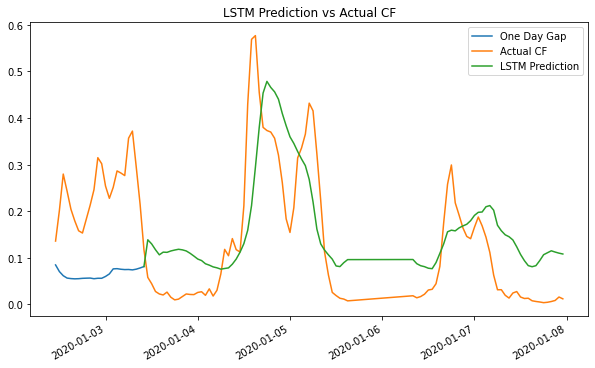

In [147]:
plt.figure(figsize=(10,6))
plt.title("LSTM Prediction vs Actual CF")
plt.plot(np.array(data_final_jan2_xgb['CF'].index), np.array(data_final_jan2_xgb['CF'].values), label='One Day Gap')
plt.plot(data[data.index >= datetime(2020,1,2,11,0,0)]['CF'], label='Actual CF')

plt.plot(np.append(np.array(data_final_jan2_xgb['CF'].index)[-1], np.array(y_pred_xgb1_test.index)), np.append(np.array(data_final_jan2_xgb['CF'].values)[-1], y_pred_lstm_test.values), label='LSTM Prediction')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [229]:
mean_absolute_error(y_test1, y_pred_lstm_test)

0.08803217101190088

## 2. Prediction

#### Fill one-day gap (Jan 8th)

In [154]:
jan8_lstm = jan8_original.copy()
jan8_lstm.shape

(24, 131)

In [155]:
final_jan8_lstm = get_test_final_LSTM(jan8_lstm, pearson_spearman)
final_jan8_lstm.shape

(24, 13)

In [156]:
full_df = pd.concat([final_data_for_training.iloc[-30:,:], final_jan8_lstm])
full_df.shape

C:\Users\13360\AppData\Local\Temp\ipykernel_3548\948739563.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([final_data_for_training.iloc[-30:,:], final_jan8_lstm])


(54, 13)

In [157]:
predict_iteratively(full_df)

1/1 [==============================] - 0s 18ms/step


#### Predict on the predict set

In [158]:
predict.shape

(93, 131)

In [159]:
final_data_for_predict = get_test_final_LSTM(predict, pearson_spearman)
final_data_for_predict.shape

(93, 13)

In [160]:
past_30_tail = full_df.iloc[-30:, :]
past_30_tail.shape

(30, 13)

In [161]:
full_predict = pd.concat([past_30_tail, final_data_for_predict])
full_predict.shape

(123, 13)

In [162]:
predict_iteratively(full_predict)

1/1 [==============================] - 0s 20ms/step


---

# Strategy Comparison

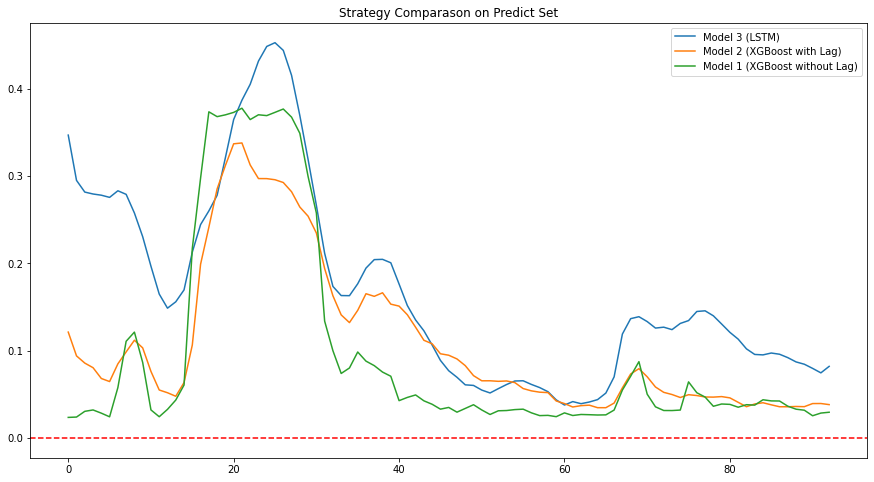

In [164]:
plt.figure(figsize=(15,8))
plt.plot(full_predict.iloc[-93:, -1].to_list(), label='Model 3 (LSTM)')
plt.plot(predict_final_xgb['CF'].to_list(), label='Model 2 (XGBoost with Lag)')
plt.plot(y_pred_xgb0, label='Model 1 (XGBoost without Lag)')
plt.title('Strategy Comparason on Predict Set')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

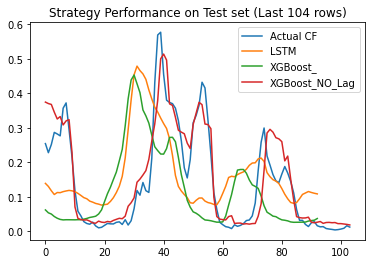

In [165]:
plt.plot(data.iloc[-104:,  0].to_list(), label='Actual CF')
plt.plot(y_pred_lstm_test.to_list(), label='LSTM')
plt.plot(y_pred_xgb1_test.to_list(), label='XGBoost_')
plt.plot(y_pred_xgb0_test_plt[-104:], label='XGBoost_NO_Lag')
plt.title('Strategy Performance on Test set (Last 104 rows)')
plt.legend()


In [227]:
mae_df = pd.DataFrame(columns=['MAE'], index = ['XGBoost without Lag', 'XGBoost with Lag', 'LSTM'])
mae_df['MAE'] = [test_mae_xgb0, mean_absolute_error(y_pred_xgb1_test, y_test1), mean_absolute_error(y_test1, y_pred_lstm_test)]
mae_df['Test Size'] = [727, 93, 93]
mae_df

MAE  Test Size
XGBoost without Lag  0.041683        727
XGBoost with Lag     0.049801         93
LSTM                 0.088032         93

In [233]:
result_to_csv = predict.copy()
result_to_csv['CF'] = y_pred_xgb0

In [237]:
result_to_csv.to_csv('Model1_Prediction.csv')